# Import packages and define global variables and functions

In [3]:
# packages needed for the following analyses
import pandas as pd
import collections
import numpy as np
import csv
from collections import defaultdict
from collections import Counter
from scipy.stats import chi2_contingency
import statsmodels.stats.multitest as smt
import glob
import statistics
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate() 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from statannot import add_stat_annotation
from scipy import stats
# workaround
from scipy.special import comb
import scipy.misc
scipy.misc.comb = comb
# workaround
import ecopy as ep
import random
from matplotlib.patches import Ellipse
import random
from scipy.stats import iqr
stats = importr('stats')

import os
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [5]:
# define global vaiables that are used across analyses

sample = pd.read_csv("srr_sample_se.csv", index_col = 0) # load sequencing metadata of samples included in this study
df_GAS = pd.read_pickle("GAS.df") # load gestational age data
sample_s = sample.set_index('Sample_Name')
sample_GAS = pd.merge(df_GAS, sample_s, left_index=True, right_index=True)
sample_GAS_s = sample_GAS.set_index('Run')

sample_ptb = sample[(sample['ptb'] == True)]
ptb_dict = defaultdict(list)
for index, row in sample_ptb.iterrows():
    ptb_dict[row['subjects']].append(row['Run']) # PTB subjects and corresponding samples

sample_tb = sample[(sample['tb'] == True)]
tb_dict = defaultdict(list)
for index, row in sample_tb.iterrows():
    tb_dict[row['subjects']].append(row['Run']) # TB subjects and corresponding samples

META = pd.read_csv('basic_meta.csv') #load sample metadata
META['GAD_int'] = META[META['GAD'].notna()]['GAD'].astype(
    str).str[:2].astype(int)

# define global functions that are used across analyses

def select_data_by_week(k, n, df): 
    """
    get sample data and subjects (median of samples) for samples from gestational week k to k+n.

    Parameters
    ----------
        k : starting week.
        n : number of weeks.
        df : a dataframe with samples as index.
        
    Returns
    -------
        a dataframe for sample data and a dataframe subject data
    """
    wk = META[(META['weeks_pregnant'] >= k) & (META['weeks_pregnant'] < k + n)]
    df_wk = df[df.index.isin(wk['Run'])]
    df_wk = df_wk.dropna(how='all', axis=1)

    ptb_tb = META[META['group'].isin(['PTB', 'TB'])]
    df_wk = df_wk[df_wk.index.isin(ptb_tb['Run'])]

    sub_dict = defaultdict(list)
    for index, row in META.iterrows():
        sub_dict[row['subjects']].append(row['Run'])

    gntdiv_sub = {}
    for k, l in sub_dict.items():
        tmp = df_wk[df_wk.index.isin(l)]
        gntdiv_sub[k] = tmp.median()
    df_wk_sub = pd.DataFrame.from_dict(gntdiv_sub, orient='index')
    df_wk_sub = df_wk_sub.dropna(how='all', axis=1)
    df_wk_sub = df_wk_sub.dropna(how='all')

    return df_wk_sub, df_wk

def fdr_sig(p_value): # 
    """
    get variables with fdr adjusted pvalues < 0.1.

    Parameters
    ----------
        p_value : a dictionary of variables with p values
        
    Returns
    -------
        a list of variables with adjusted p value < 0.1
    """
    p_v = []
    for c_key in p_value:
        p_v.append(p_value[c_key])
    array = np.array(p_v)
    rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
    p_corr = pvalscorr.tolist()
    n_p = 0
    sig_fdr = []
    for c_key in p_value:
        if p_corr[n_p] < 0.1:
            print('FDR', c_key, p_corr[n_p])
            sig_fdr.append(c_key)
        n_p = n_p + 1
    return sig_fdr

def ptb_tb_sub_median(df):
    
    """
    get median of sample values for PTB and TB subjects for phylogroups included in df.

    Parameters
    ----------
        df : a dataframe with samples as index and phylogroups as columns.
        
    Returns
    -------
        a list of values for PTB subjects and a lost of values for TB subjects

    """
    ptb_sub = defaultdict(list)
    tb_sub = defaultdict(list)
    for (columnName, columnData) in df.iteritems(): 
        for key in ptb_dict:
            result = []
            for item in ptb_dict[key]:
                if item in df.index:
                    result.append(df.loc[item][columnName])
            a_ptb = [x for x in result if str(x) != 'nan']
            if len(a_ptb) != 0:
                ptb_av = statistics.median(a_ptb) # get median of samples for each PTB subject
                ptb_sub[key].append(ptb_av)
        for key_ in tb_dict:
            result_ = []
            for item_ in tb_dict[key_]:
                if item_ in df.index:
                    result_.append(df.loc[item_][columnName])
            a_tb = [x for x in result_ if str(x) != 'nan']
            if len(a_tb) != 0:
                tb_av = statistics.median(a_tb) # get median of samples for each TB subject
                tb_sub[key_].append(tb_av)
    ptb_ab=[]
    tb_ab=[]
    for ptbi in ptb_sub:
        ptb_ab.append(statistics.median(ptb_sub[ptbi])) # get median of all phylgroups
    for tbi in tb_sub:
        tb_ab.append(statistics.median(tb_sub[tbi])) # get median of all phylgroups

    return ptb_ab, tb_ab



# Compositional tensor factorization (CTF)

In [4]:
# load restuls from CTF analysis
ctf = pd.read_csv('Subject_loadings_PERMANOVA_P_0.002.csv',index_col=0)
meta = META[['subjects', 'group']].drop_duplicates().set_index('subjects')
ctf_gp = pd.merge(ctf, meta, left_index = True, right_index = True)

## Fig. 1b Scatter plot for CTF 2 components

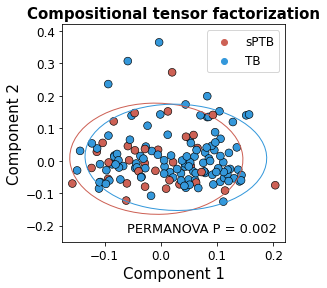

In [3]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

plt.rcParams["figure.figsize"] = (4, 4)
ax = sns.scatterplot(x='Component 1', y='Component 2', hue='group', data = ctf_gp, 
                     palette={'PTB':'#CD6155', 'TB':'#3498DB'}, 
                     s=60, edgecolor='black')

e1 = plot_point_cov(ctf_gp[ctf_gp['group'] == 'PTB'][['Component 1', 'Component 2']].values)
e2 = plot_point_cov(ctf_gp[ctf_gp['group'] == 'TB'][['Component 1', 'Component 2']].values)
e1.set_facecolor('none')
e2.set_facecolor('none')
e1.set_edgecolor('#CD6155')
e2.set_edgecolor('#3498DB')


handles, labels = ax.get_legend_handles_labels()
labels = ['sPTB', 'TB']
ax.legend(handles, labels, title='', fontsize=12)


plt.xlabel('Component 1', size=15)
plt.ylabel('Component 2', size=15)
plt.ylim(-0.25, 0.42)
plt.title('Compositional tensor factorization', size=15, fontweight='bold')
plt.text(-0.06, -0.22, 'PERMANOVA P = 0.002', color='black', fontsize=13)
plt.savefig('ctf_pca.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 1c CFT Compent 1 difference comparied between sPTB and TB

35 111
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.456e-02 U_stat=1.409e+03


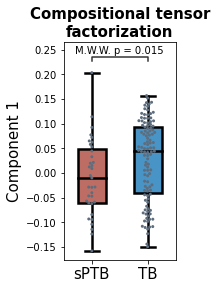

In [5]:
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = ctf_gp[ctf_gp['group'] == 'PTB']['Component 1']
tb_ab = ctf_gp[ctf_gp['group'] == 'TB']['Component 1']
print(len(ptb_ab), len(tb_ab))

boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
# ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Compositional tensor\nfactorization", size=15, fontweight='bold')
plt.ylabel('Component 1', size=15)
plt.xlabel('')
plt.savefig('CTF_comp1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 1d Feature loadings for CFT component 1

In [6]:
# load feature loadings result from CTF analysis

feature = pd.read_csv('Feature_loadings.csv',index_col=0)
con = pd.concat([feature.sort_values('Component 2').head(5), feature.sort_values('Component 2').tail(5)])
key = ['Lactobacillus helveticus PG81', 'Lactobacillus crispatus PG80', 'Lactobacillus gasseri PG79', 
       'Lactobacillus jensenii PG76', 'Lactobacillus jensenii PG77', 'Gardnerella vaginalis PG50', 
       'Megasphaera genomosp PG61', 'Gardnerella vaginalis PG52', 'Gardnerella vaginalis PG47', 
       'Atopobium vaginae PG41']
group = ['TB', 'TB', 'TB', 'TB', 'TB', 'PTB', 'PTB', 'PTB', 'PTB', 'PTB']
dic = {'PC2': con['Component 2'], 'taxa': key, 'group': group}
df = pd.DataFrame.from_dict(dic)

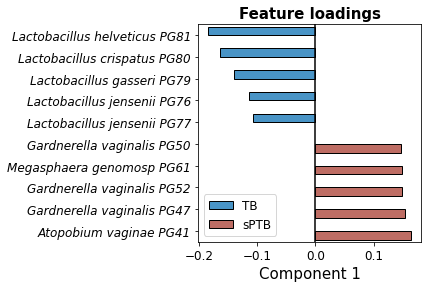

In [7]:
plt.rcParams["figure.figsize"] = (4, 4)
ax = sns.barplot(data=df,
                 x='PC2',
                 y='taxa',
                 hue='group',
                 palette={'PTB':'#CD6155', 'TB':'#3498DB'},
                 edgecolor='black')

plt.axvline(0, c='black')

handles, labels = ax.get_legend_handles_labels()
labels = ['TB', 'sPTB']
ax.legend(handles, labels, title='', fontsize=12)
plt.xlabel('Component 1', size=15)
plt.ylabel('', size=15)
plt.yticks(style='italic')
plt.title('Feature loadings', size=15, fontweight='bold')
plt.savefig('ctf_features.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 1e Temporal changes of the top taxa in Fig. 1d

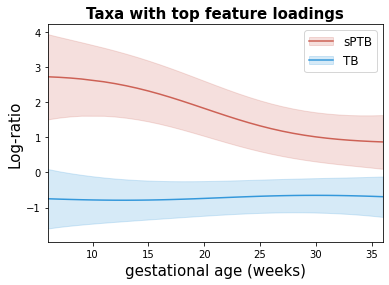

In [46]:
x = pd.read_csv('CTF_Time.csv').drop(['Unnamed: 0', 'feature'], axis = 1)
s = x.groupby(['group', 'time']).first().reset_index()
x.groupby('group').min().max()

plt.close('all')
t = s[s.group == 'PTB']
line_1, = plt.plot(t.time, t['mean'], '#CD6155')
fill_1 = plt.fill_between(t.time, t['mean'] - 1.959964 * t.merr, t['mean'] + 1.959964 * t.merr, color='#CD6155', alpha=0.2)
t = s[s.group == 'TB']
line_2, = plt.plot(t.time, t['mean'], '#3498DB')
fill_2 = plt.fill_between(t.time, t['mean'] - 1.959964 * t.merr, t['mean'] + 1.959964 * t.merr, color='#3498DB', alpha=0.2)

plt.rcParams["figure.figsize"] = (6, 4)
plt.margins(x=0)
plt.xlim(x.groupby('group').min().max().time, x.groupby('group').max().min().time)
plt.title('Taxa with top feature loadings', size=15, fontweight='bold')
plt.legend([(line_1, fill_1), (line_2, fill_2)], ['sPTB', 'TB'], fontsize=12)
plt.ylabel('Log-ratio', size=15)
plt.xlabel('gestational age (weeks)', size=15)
plt.savefig('log_ratio_top_taxa.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Average nucleotide identify (ANI) of strains compared between subjects

In [ ]:
# select phylogroups that have at leat 10 MAGs assembed from PTB subjects
bins_mag = pd.read_csv('allbins2genome.tsv', sep = '\t', index_col=0)
bins = pd.read_csv('genomic_bins_metabat.tsv', sep = '\t', index_col=0)
df_m = pd.merge(bins_mag, bins, left_index=True, right_index=True) 

sample['group'] = sample['ptb'].replace({False:'ftb', True:'ptb'}) 
sample_new = sample.drop(['tb', 'ptb'], axis = 1)
sample_new = sample_new.set_index(['Sample_Name'])
df_GAS = pd.read_pickle("GAS.df")
sample_GAS = sample_new.join(df_GAS)
sample_GAS = sample_GAS.reset_index()
sample_GAS = sample_GAS.set_index(['Run'])
df_m_GAS = pd.merge(df_m, sample_GAS, left_on = 'Sample', right_index=True, how = 'left')
df_m_GAS["ad_genomesize"] = (df_m_GAS["Genome size (Mbp)"]*(1-df_m_GAS["Contamination"]*0.01)/df_m_GAS["Completeness"])*100

mag_dic = defaultdict(list)
sub_dic = defaultdict(list)
group_dic = defaultdict(list)
for index, row in df_m_GAS.iterrows():
    mag_dic[row['MAG']].append(row['Sample'])
    sub_dic[row['MAG']].append(row['subjects'])
    group_dic[row['MAG']].append(row['group'])
mag_sum = defaultdict(list)
for key in mag_dic:
    sa = len(mag_dic[key])
    sa_u = len(set(mag_dic[key]))
    sub = len(set(sub_dic[key]))
    d = Counter(group_dic[key])
    n, m = d.keys(), d.values()
    if len(list(n)) > 1:
        if list(m)[1] > 9:
            print(key)
            print(sa)
            print(sa_u)
            print(sub)
            print(list(m))
            print(df_m_GAS.loc[df_m_GAS['MAG'] == key, 'Taxonomy (contained)'].iloc[0])
            
df_m_GAS_se = df_m_GAS[(df_m_GAS['MAG'].str.contains('MAG038'))|(df_m_GAS['MAG'].str.contains('MAG061'))| (df_m_GAS['MAG'].str.contains('MAG086')) | (df_m_GAS['MAG'].str.contains('MAG113'))]
df_m_GAS_se.to_pickle("selected_mag_sample_meta.pkl")

## Supplementary Fig. 2 ANI of MAGs clssified as M. genomosp

In [ ]:
# compare observed ANI of MAGs within sPTB subjects and TB subjects with expected ANI for selected phylogroups 
metadata = pd.read_pickle('selected_mag_sample_meta.pkl')
for fname in glob.glob('*.tab'): # ANI matrix
    ani_matrix = pd.read_csv(fname, sep = '\t', index_col=0)
    sub_dic = defaultdict(list)
    new_meta = metadata[metadata['MAG'] == fname.split('/')[-1].split('_')[0]]
    for index, row in new_meta.iterrows():
        sub_dic[row['subjects']].append(index)
    ptb_count1 = ftb_count1 = ptb_count2 = ftb_count2 = 0
    ptb_per = []
    ftb_per = []
    ram_per = []
    for i in range(0, 1000): # randomly select MGS from a pool both sPTB and TB subjects and repeat for 1000 times
        mag_s = []
        for skey in sub_dic:
            sel = random.sample(sub_dic[skey], k=1)
            mag_s.append(sel[0]) 
        ani_matrix_n = ani_matrix[ani_matrix.index.isin(mag_s)]
        ani_matrix_n = ani_matrix_n[mag_s]
        ani_list = ani_matrix_n.stack().reset_index().rename(columns={'level_0':'A','level_1':'B', 0:'ANI'})
        my_dict = {}
        for index, row in ani_list.iterrows():
            pair_dis = set()
            pair_dis.add(row['A'])
            pair_dis.add(row['B'])
            my_dict[frozenset(pair_dis)] = row['ANI']
        ptb_ani = []
        ftb_ani = []
        inter_ani = []
        for k in my_dict.keys():
            if len(k) != 1:
                to_write = sorted(list(k))
                if metadata.loc[to_write[0]]['group'] == 'ptb' and metadata.loc[to_write[1]]['group'] == 'ptb':
                    ptb_ani.append(my_dict[k])
                elif metadata.loc[to_write[0]]['group'] == 'ftb' and metadata.loc[to_write[1]]['group'] == 'ftb':
                    ftb_ani.append(my_dict[k])
                else:
                    inter_ani.append(my_dict[k])
        ptb_ani = [x for x in ptb_ani if x >= 0.95]
        ftb_ani = [x for x in ftb_ani if x >= 0.95]
        inter_ani = [x for x in inter_ani if x >= 0.95]
        all_ani = ptb_ani + ftb_ani + inter_ani
        kmin = len(ptb_ani)
        ftb_ani_se = random.sample(ftb_ani, k=kmin)
        ram = random.sample(all_ani, k=kmin)
        ram_mean = statistics.mean(ram)
        ptb_mean = statistics.mean(ptb_ani)
        ftb_mean = statistics.mean(ftb_ani_se)
        ram_per.append(ram_mean)
        ptb_per.append(ptb_mean)
        ftb_per.append(ftb_mean)
        if ptb_mean < ram_mean:
            ptb_count1+=1
        if ptb_mean > ram_mean:
            ptb_count2+=1
        if ftb_mean < ram_mean:
            ftb_count1+=1
        if ftb_mean > ram_mean:
            ftb_count2+=1
    ptb_pv = ptb_count1/1000+1-ptb_count2/1000 # pvalue for sPTB
    ptb_pv = "%.4f" % ptb_pv
    ftb_pv = 1-ftb_count1/1000+ftb_count2/1000 # pvalue for TB
    ftb_pv = "%.4f" % ftb_pv
    print(fname.split('/')[-1], ptb_pv, ftb_pv)
    ani_label = ['null'] * len(ram_per)
    ani_dic = pd.DataFrame(list(zip(ani_label, ram_per)), columns =['Name', 'Ani'])
    
    
    plt.figure()
    plt.rcParams["figure.figsize"] = (4, 4)
    ax = sns.histplot(data=ani_dic, x='Ani', element='step', color='grey')
    spe = metadata.loc[metadata['MAG'] == fname.split('/')[-1].split('_')[0], 'Taxonomy (contained)'].iloc[0].split(';')[-1] 
    
    plt.xlabel("ANI", size = 18)
    plt.ylabel("Count", size=18)
    plt.title(spe, size=15, fontweight='bold')
    plt.xticks(size = 15, rotation=45)
    ax.axvline(x=statistics.mean(ptb_per), color='#CD6155', lw=2.5)
    ax.axvspan(statistics.mean(ptb_per)-statistics.stdev(ptb_per), statistics.mean(ptb_per)+statistics.stdev(ptb_per), alpha=0.1, color='#CD6155')
    ax.axvline(x=statistics.mean(ftb_per), color='#3498DB', lw=2.5)
    ax.axvspan(statistics.mean(ftb_per)-statistics.stdev(ftb_per), statistics.mean(ftb_per)+statistics.stdev(ftb_per), alpha=0.1, color='#3498DB')
    plt.savefig(fname[:-4] + '_subject_permutation_ERiden_1000.pdf', bbox_inches='tight')
    plt.show()

# InStrain (population genetics analyses)

## Nucleotide diversity

## Supplementary Fig. 3a Nucleotide diversity of phylogroups significatnly differeing between sPTB and TB

24 66
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.731e-04 U_stat=1.161e+03


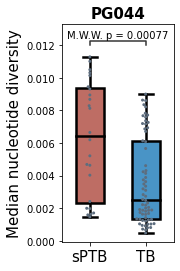

12 35
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.559e-02 U_stat=3.020e+02


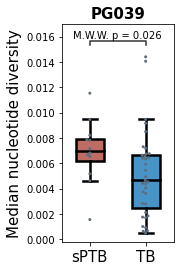

20 50
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.835e-01 U_stat=5.830e+02


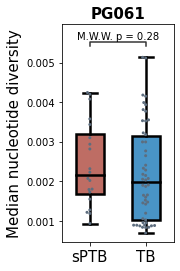

17 38
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.359e-02 U_stat=4.590e+02


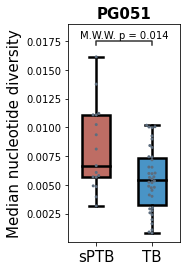

23 56
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.004e-02 U_stat=8.600e+02


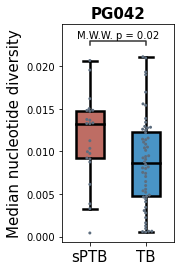

17 38
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.748e-01 U_stat=3.980e+02


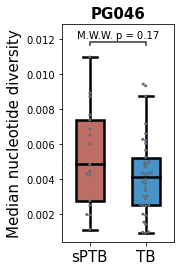

21 49
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.835e-01 U_stat=5.830e+02


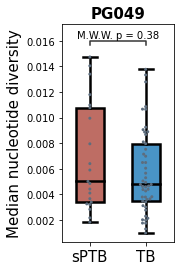

21 56
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.830e-03 U_stat=8.250e+02


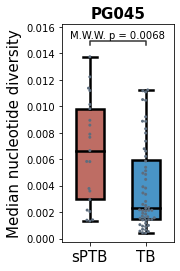

In [6]:
# load nucleotide diversity for phylogroups that are significantly different between sPTB and TB
gw = pd.read_csv('genome_wide_metx_sub_median.csv')
mag_sig = set(gw[gw['fdr'] < 0.1]['MAG'])

plt.rcParams["figure.figsize"] = (2, 4)
df = pd.read_pickle('nt.df').T
df_sig = df[mag_sig]
for (columnName, columnData) in df_sig.iteritems(): 
    ptb_ab = []
    tb_ab = []
    for key in ptb_dict:
        result = []
        for item in ptb_dict[key]:
            if item in df_sig.index:
                result.append(df_sig.loc[item][columnName])
        a_ptb = [x for x in result if str(x) != 'nan']
        if len(a_ptb) != 0:
            ptb_av = statistics.median(a_ptb)
            ptb_ab.append(ptb_av)
    for key_ in tb_dict:
        result_ = []
        for item_ in tb_dict[key_]:
            if item_ in df_sig.index:
                result_.append(df_sig.loc[item_][columnName])
        a_tb = [x for x in result_ if str(x) != 'nan']
        if len(a_tb) != 0:
            tb_av = statistics.median(a_tb)
            tb_ab.append(tb_av)
    if len(ptb_ab) != 0 and len(tb_ab) != 0:
        print(len(ptb_ab), len(tb_ab))
        boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
        lineprops = {'color': 'k', 'linewidth': 2.5}
        boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
        ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
        ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
        test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                          pvalue_format_string="{:.2g}")
        ax.set_xticklabels(['sPTB', 'TB'], size=15)
        ax.set_title('PG' + columnName[3:-6], size=15, fontweight='bold')
        plt.ylabel('Median nucleotide diversity', size=15)
        plt.xlabel('')
        plt.savefig('columnName + '_ntdiversity.pdf', bbox_inches='tight', dpi = 300)
        plt.show()

## Fig. 2a Nucleotide diversity of all phylogroups compaed between sPTB and TB subjects

37 135
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.295e-03 U_stat=3.218e+03


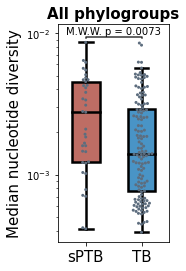

In [9]:
df = pd.read_pickle('nt.df').T
ptb_ab, tb_ab = ptb_tb_sub_median(df)

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("All phylogroups", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 2b Nucleotide diversity of Gardnerella spp. compared between sPTB and TB subjects

30 79
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.741e-02 U_stat=1.536e+03


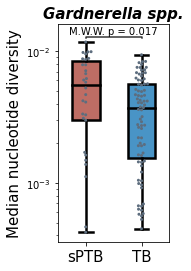

In [47]:
df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]
df_sig = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]
ptb_ab, tb_ab = ptb_tb_sub_median(df_sig)  

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.", size=15, fontweight='bold', style='italic')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_ntdiversity_subject.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 2c Trajectory of median nucleotide diversity of Gardnerella spp.

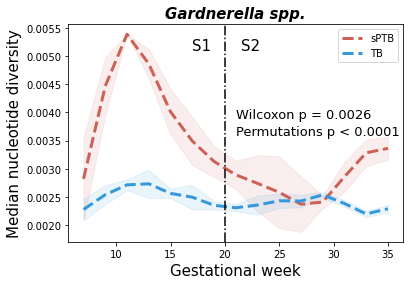

In [48]:
temp = pd.read_csv('Temporal_analysis_binned_splines_w_IQR.csv')

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(temp['pregnancy_weeks_binned'], temp['fit_PTB.y'], linestyle='--', label='sPTB', color='#CD6155', lw=3)
plt.plot(temp['pregnancy_weeks_binned'], temp['fit_TB.y'], linestyle='--', label='TB', color='#3498DB', lw=3)

plt.fill_between(temp['pregnancy_weeks_binned'], temp['fit_PTB.y']-np.sqrt(temp['PTB_var'])/temp['PTB_num_samples'], 
                 temp['fit_PTB.y']+np.sqrt(temp['PTB_var'])/temp['PTB_num_samples'], alpha=0.1, 
                 edgecolor='#CD6155', facecolor='#CD6155', linewidth=1)

plt.fill_between(temp['pregnancy_weeks_binned'], temp['fit_TB.y']-np.sqrt(temp['TB_var'])/temp['TB_num_samples'], 
                 temp['fit_TB.y']+np.sqrt(temp['TB_var'])/temp['TB_num_samples'], alpha=0.1, 
                 edgecolor='#3498DB', facecolor='#3498DB', linewidth=1)

plt.xlabel('Gestational week', fontsize=15)
plt.ylabel('Median nucleotide diversity', fontsize=15)
plt.text(21, 0.0039, 'Wilcoxon p = 0.0026', color='black', fontsize=13)
plt.text(21, 0.0036, 'Permutations p < 0.0001', color='black', fontsize=13)
plt.text(17, 0.0051, 'S1', color='black', fontsize=15)
plt.text(21.5, 0.0051, 'S2', color='black', fontsize=15)
plt.axvline(x=20, color = 'black', ls='-.')
plt.legend()
plt.title('Gardnerella spp.', size=15, fontweight='bold', style='italic')
plt.savefig('nt_div_temp.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 2d and e Nucleotide diversity of Gardnerella spp. compared between sPTB and TB subjects for S1 (first half of pregnancy) and S2 (second half of pregnancy)

In [ ]:
df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]
df = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

18 41
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.074e-03 U_stat=5.280e+02


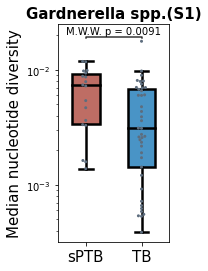

In [50]:
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df = df_s1.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops, 'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.(S1)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_ntdiversity_subject_S1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

23 59
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.102e-01 U_stat=7.150e+02


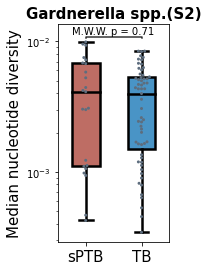

In [51]:
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df = df_s2.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.(S2)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_ntdiversity_subject_S2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 2f and g Nucleotide diversity of all phylogroups compared between sPTB and TB subjects for S1 and S2

In [ ]:
df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

24 90
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.628e-03 U_stat=1.499e+03


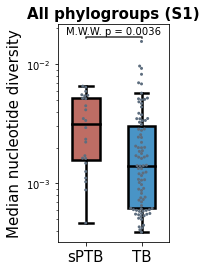

In [17]:
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df = df_s1.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops, 'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("All phylogroups (S1)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_S1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

35 116
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.563e-01 U_stat=2.352e+03


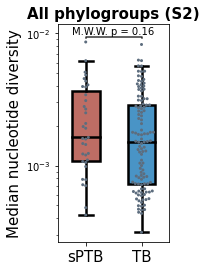

In [18]:
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df = df_s2.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("All phylogroups (S2)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_S2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Validation using Relman data

In [7]:
# process metadata

term = [10039, 10044, 10034, 10032, 10047, 10046] # ID's of subjects with term birth
preterm = [10101, 10031, 10036, 10029] # ID's of subjects with preterm birth

gamd = pd.read_csv('pnas.1502875112.sd02.txt', sep = '\t')
# create Dataframe that maps subject IDs to the ID's of their sample sequencing runs
meta = pd.read_csv("/Relman_Meta.txt", sep="\t", usecols=["Run","Sample_ID"])
meta["subject"] = meta["Sample_ID"].apply(lambda row: str(row)[:5])
meta.sort_values(by=["subject"], inplace=True)

meta['Sample_ID'] = meta.Sample_ID.astype(str)
meta = meta.merge(gamd[['#SampleID', 'GestationalWeekOfCollection', 'PretermBirth', 'GestationalWeekOfDelivery']], 
           left_on = 'Sample_ID', right_on = '#SampleID', how = 'left')
meta['Sample_ID'] = meta.Sample_ID.astype(int)
meta.head()

meta = meta.set_index('Run')

s1_meta = meta[(meta['GestationalWeekOfCollection'] < 20)]

s2_meta = meta[(meta['GestationalWeekOfCollection'] >= 20) & (meta['GestationalWeekOfCollection'] < 37)]

## Fig. 2h and i Nucleotide diversity of all phylogroups compared between sPTB and TB subjects for S1 and S2 

one-sided MW p: 0.021412804615445674
4 6


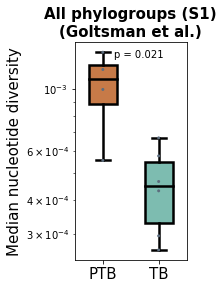

In [26]:
df = pd.read_pickle('relman_nt.df').T
df.columns = df.columns.str.split('.').str[0]

# calculate median of samples for each subject

median_sample = pd.merge(s1_meta[['subject']], df, left_index=True, right_index=True).groupby('subject').median()
median_mag = median_sample.median(axis=1)

# get median of mag for PTB subjects
ptb_ab = median_mag[median_mag.index.isin(meta[(meta['PretermBirth'] == True)]['subject'])] 

# get median of mag for TB subjects
tb_ab = median_mag[median_mag.index.isin(meta[(meta['PretermBirth'] == False)]['subject'])] 

u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='greater')
print('one-sided MW p:', prob)

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#DC7633', '#73C6B6'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
ax.set_xticklabels(['PTB', 'TB'], size=15)
ax.set_title("All phylogroups (S1)\n(Goltsman et al.)", size=15, fontweight='bold')
plt.annotate('p = 0.021', (0.2, 0.0013))
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_S1_relman.pdf', bbox_inches='tight', dpi = 300)
plt.show()

one-sided MW p: 0.12047733435078506
4 6


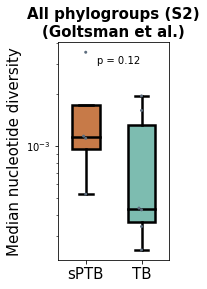

In [30]:
# calculate median of samples for each subject

median_sample = pd.merge(s2_meta[['subject']], df, left_index=True, right_index=True).groupby('subject').median()
median_mag = median_sample.median(axis=1)

# get median of mag for PTB subjects
ptb_ab = median_mag[median_mag.index.isin(meta[(meta['PretermBirth'] == True)]['subject'])] 

# get median of mag for TB subjects
tb_ab = median_mag[median_mag.index.isin(meta[(meta['PretermBirth'] == False)]['subject'])] 

u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='greater')
print('one-sided MW p:', prob)

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#DC7633', '#73C6B6'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
plt.annotate('p = 0.12', (0.2, 0.003))
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("All phylogroups (S2)\n(Goltsman et al.)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_S2_relman.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 3b Spearman correlation coefficient between nucleotide diversity and number of synonymous mutations and nonsynonymous mutations Gardnerella spp.

In [24]:
from scipy import stats
ntdiv = pd.read_pickle('gntdiv.df')
snv_s = pd.read_pickle('snv_s.df')
snv_n = pd.read_pickle('snv_n.df')
gv_all=['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']
r_s_ls = []
r_n_ls = []
for gv in gv_all:
    ntdiv_gv = ntdiv[ntdiv.index.str.split('_').str[0] == gv]
    snv_s_gv = snv_s[snv_s.index.str.split('_').str[0] == gv]
    snv_n_gv = snv_n[snv_n.index.str.split('_').str[0] == gv]
    ntdiv_aver = pd.DataFrame(ntdiv_gv.mean(axis=1))
    ntdiv_aver.columns = ['ntdiv']

    snv_s_aver = pd.DataFrame(snv_s_gv.mean(axis=1))
    snv_s_aver.columns = ['snv_s']

    snv_n_aver = pd.DataFrame(snv_n_gv.mean(axis=1))
    snv_n_aver.columns = ['snv_n']

    ntdiv_snv_s = pd.merge(ntdiv_aver, snv_s_aver, left_index=True, right_index=True)
    ntdiv_snv_n = pd.merge(ntdiv_aver, snv_n_aver, left_index=True, right_index=True)

    ntdiv_snv_s = ntdiv_snv_s[ntdiv_snv_s['snv_s'] != 0]
    ntdiv_snv_n = ntdiv_snv_n[ntdiv_snv_n['snv_n'] != 0]

    ntdiv_snv_s['snv_s']= np.log10(ntdiv_snv_s['snv_s'])
    ntdiv_snv_n['snv_n']= np.log10(ntdiv_snv_n['snv_n'])
    
    r_s, p_s = stats.spearmanr(list(ntdiv_snv_s['ntdiv']), list(ntdiv_snv_s['snv_s']))
    r_n, p_n = stats.spearmanr(list(ntdiv_snv_n['ntdiv']), list(ntdiv_snv_n['snv_n']))
    r_s_ls.append(r_s)
    r_n_ls.append(r_n)

0 v.s. 1: t-test paired samples with Bonferroni correction, P_val=1.077e-03 stat=4.392e+00


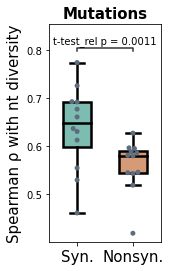

In [33]:
plt.rcParams["figure.figsize"] = (2, 4)

boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[r_s_ls, r_n_ls], palette=['#73C6B6', '#E59866'], **boxplot_kwargs, showfliers=False)
# ax.set_yscale('log')
ax = sns.swarmplot(data=[r_s_ls, r_n_ls], color="#5D6D7E", size=5)
test_results = add_stat_annotation(ax, data=[r_s_ls, r_n_ls], box_pairs=[(0, 1)],
                               test='t-test_paired', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['Syn.', 'Nonsyn.'], size=15)
ax.set_title("Mutations", size=15, fontweight='bold')
plt.ylabel('Spearman ρ with nt diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_ntdiversity_snv_cor.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Check bias caused by medical intervention

In [ ]:
# load medical data
df_intv = pd.read_pickle("rev_of_sys_mrg.df") # load clinical data
meta = pd.read_csv("basic_meta.csv") # load clinical data
meta = meta.set_index('Sample_Name')
df_intv_merge = pd.merge(df_intv, meta, left_index=True, right_index=True)

df_intv_use = df_intv_merge[df_intv_merge['group'] != 'OTHER']
df_intv_use = df_intv_use.set_index('subjects')
df_intv_use = df_intv_use[~df_intv_use.index.duplicated(keep='first')]

# Fisher's exact testing if dstribution of pregnancy outcome is dependent on cerclage or progesterone
print(pd.crosstab(df_intv_use['cerclage'], df_intv_use['group']))

print('cerclage', fisher_exact(np.array([[83, 3],[382, 13]]), alternative='two-sided'))

print(pd.crosstab(df_intv_use['progesterone'], df_intv_use['group']))

print('progesterone', fisher_exact(np.array([[78, 9],[364, 25]]), alternative='two-sided'))

## Supplementary Fig. 4a and b Nucleotide diversity of all phylogroups compared between sPTB and TB for subjects receive no cerclage and progesterone for S1 and S2. 

In [ ]:
df_intv = pd.read_pickle("rev_of_sys_mrg.df")
meta = pd.read_csv("basic_meta.csv")
meta = meta.set_index('Sample_Name')
df_intv_merge = pd.merge(df_intv, meta, left_index=True, right_index=True)

df_intv_use = df_intv_merge[df_intv_merge['group'] != 'OTHER']
df_intv_use = df_intv_use.set_index('Run')
df_cerc_progest = df_intv_use[(df_intv_use['cerclage'] == 'No') & df_intv_use['progesterone'] != 'No']

df = pd.read_pickle('nt.df').T
df = df[df.index.isin(df_cerc_progest.index)]

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 37, df)

13 35
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.752e-02 U_stat=3.230e+02


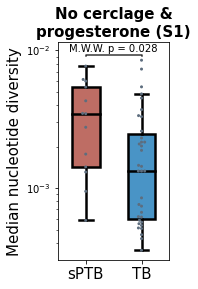

In [36]:
ptb_ab = []
tb_ab =[]
df = df_s1.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))


plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("No cerclage &\nprogesterone (S1)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_nocerclageprogesterone_S1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

30 127
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.208e-01 U_stat=2.253e+03


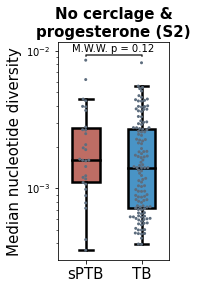

In [39]:
ptb_ab = []
tb_ab =[]
df = df_s2.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("No cerclage &\nprogesterone (S2)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('All_ntdiversity_subject_nocerclageprogesterone_S2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 2j Nucleotide diversity of genes compared between sPTB nd TB and function of significantly enriched genes

In [ ]:
df = pd.read_pickle('gntdiv.df').T

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

In [ ]:
# find genes that are significantly different between sPTB and TB after FDR correction
mag_gene = {}

for (columnName, columnData) in df_s1.iteritems():
     mag_gene[columnName.split('_')[0]] = {}
for (columnName, columnData) in df_s1.iteritems(): 
    ptb_ab=[]
    tb_ab=[]
    for index, row in df_s1.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    if len(set(ptb_ab)) > 1 and len(set(tb_ab)) > 1:
        u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='two-sided')
        mag_gene[columnName.split('_')[0]].update({columnName:prob})
        
mag_sig = {}
for key in mag_gene:
    if len(mag_gene[key]) > 0:
        print(key, len(mag_gene[key]))
        sig_fdr = fdr_sig(mag_gene[key])
        if len(sig_fdr) > 0:
            mag_sig[key] = sig_fdr

In [17]:
# identify COG and KEGG functional categories that significantly enriched among significant genes using permutation
eggnog = pd.read_csv('all_eggnog.emapper.annotations', sep='\t', header=None)
header = ['query_name', 'seed eggNOG ortholog', 'seed ortholog evalue', 'seed ortholog score', 'Predicted taxonomic group', 'Predicted protein name', 'Gene Ontology terms', 'EC number', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG Reaction', 'tax_scope: eggNOG taxonomic level used for annotation', 'eggNOG OGs', 'NA|NA|NA', 'COG Functional Category', 'eggNOG free text description']
eggnog.columns = header
eggnog = eggnog.set_index('query_name')
eggnog['MAG'] = eggnog.index.str.split('_').str[0]
eggnog['COG Functional Category'] = eggnog['COG Functional Category'].fillna('S')
eggnog['KEGG_Pathway'] = eggnog['KEGG_Pathway'].fillna('ko99999')

mag_gene_pl = defaultdict(list)
for index, row in eggnog.iterrows():
    mag_gene_pl[row['MAG']].append(index)


def permutation(dic, dic_random):
    p_value = {}
    p_value_sig = []
    for ob in dic:
        frequency_ra = dic_random[ob]
        frequency_ob = dic[ob]
        count_larger = len([x for x in frequency_ra if x >= frequency_ob])
        p = count_larger/10000
        p_value[ob] = p
        if p < 0.05:
            print(p)
            p_value_sig.append(ob)
    return p_value_sig, p_value

for key in mag_sig:
    eggnog_mag = eggnog[eggnog['MAG'] == key]
    gene_ob = mag_sig[key]
    ngene = len(gene_ob)
    cog_ob = eggnog_mag[eggnog_mag.index.isin(gene_ob)]['COG Functional Category'].tolist()
    cog_ob_ind = []
    for ind in cog_ob:
        for stri in ind:
            cog_ob_ind.append(stri)
    count_ob_cog = collections.Counter(cog_ob_ind)
    
    kegg_ob = eggnog_mag[eggnog_mag.index.isin(gene_ob)]['KEGG_Pathway'].tolist()
    kegg_ob_ind = []
    for kegg_ind in kegg_ob:
        for kegg_stri in kegg_ind.split(','):
            if 'ko' in kegg_stri:
                kegg_ob_ind.append(kegg_stri)
    count_ob_kegg = collections.Counter(kegg_ob_ind)
    
    random_fre_cog = defaultdict(list)
    random_fre_kegg = defaultdict(list)
    for i in range(0, 10000):
        gene_ra = random.sample(mag_gene_pl[key], k=ngene)
        cog_ra = eggnog_mag[eggnog_mag.index.isin(gene_ra)]['COG Functional Category'].tolist()
        cog_ra_ind = []
        for ra_ind in cog_ra:
            for ra_stri in ra_ind:
                cog_ra_ind.append(ra_stri)
        count_ra_cog = collections.Counter(cog_ra_ind)
        for ra_cog in count_ra_cog:
            random_fre_cog[ra_cog].append(count_ra_cog[ra_cog])

        kegg_ra = eggnog_mag[eggnog_mag.index.isin(gene_ra)]['KEGG_Pathway'].tolist()
        kegg_ra_ind = []
        for kegg_ind_ra in kegg_ra:
            for kegg_ra_stri in kegg_ind_ra.split(','):
                if 'ko' in kegg_ra_stri:
                    kegg_ra_ind.append(kegg_ra_stri)
        count_ra_kegg = collections.Counter(kegg_ra_ind)
        for ra_kegg in count_ra_kegg:
            random_fre_kegg[ra_kegg].append(count_ra_kegg[ra_kegg])
            
    p_sig_cog, p_cog = permutation(count_ob_cog, random_fre_cog)
    p_sig_kegg, p_kegg = permutation(count_ob_kegg, random_fre_kegg)
          
    print(key, ngene, p_sig_cog, fdr_sig(p_cog), p_sig_kegg, fdr_sig(p_kegg))

0.0024
0.0204
MAG044 21 [] [] ['ko00983', 'ko00500'] ['ko00983']
0.0241
0.0366
MAG043 47 [] [] ['ko04112', 'ko00550'] []


In [ ]:
# Make a volcano plot for MAG044 genes and highlight ko00983

# get p values and fold change
pval = {}
fold = {}
for (columnName, columnData) in df_s1.iteritems(): 
    if 'MAG044' in columnName:
        ptb_ab=[]
        tb_ab=[]
        for index, row in df_s1.iterrows():
            if str(row[columnName]) != 'nan':
                if index in ptb_dict:
                    ptb_ab.append(row[columnName])
                else:
                    tb_ab.append(row[columnName])
        if len(set(ptb_ab)) > 1 and len(set(tb_ab)) > 1:
            u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='two-sided')
            pval[columnName] = prob
            fold[columnName] = statistics.median(ptb_ab)/statistics.median(tb_ab)
            
# get fdr adjusted p value            
p_v = []
for c_key in pval:
    p_v.append(pval[c_key])
array = np.array(p_v)
rej, pvalscorr, _, _ = smt.multipletests(array, method = 'fdr_bh')
p_corr = pvalscorr.tolist()
n_p = 0
fdr = {}
for c_key in pval:
    fdr[c_key] = p_corr[n_p]
    n_p = n_p + 1
    
# assign 'drug' to 'ko00983' and other kegg 'others'   
eggnog = pd.read_csv('all_eggnog.emapper.annotations', sep='\t', header=None)
header = ['query_name', 'seed eggNOG ortholog', 'seed ortholog evalue', 'seed ortholog score', 'Predicted taxonomic group', 'Predicted protein name', 'Gene Ontology terms', 'EC number', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 'BRITE', 'KEGG_TC', 'CAZy', 'BiGG Reaction', 'tax_scope: eggNOG taxonomic level used for annotation', 'eggNOG OGs', 'NA|NA|NA', 'COG Functional Category', 'eggNOG free text description']
eggnog.columns = header
eggnog = eggnog.set_index('query_name')
eggnog['MAG'] = eggnog.index.str.split('_').str[0]
eggnog['COG Functional Category'] = eggnog['COG Functional Category'].fillna('S')
eggnog['KEGG_Pathway'] = eggnog['KEGG_Pathway'].fillna('ko99999')

keg = {}
for index, row in eggnog.iterrows():
    if index in fdr:
        if 'ko00983' in row['KEGG_Pathway']:
            keg[index] = 'drug'
        else:
            keg[index] = 'others'  
            
#take the log2 of fold change and -log10 of fdr adjusted p value

dic_kegg = {}
for key in keg:
    dic_kegg[key] = [np.log2(fold[key]), -np.log10(fdr[key]), keg[key]]  
    
# prepare dataframe for making plot

df_kegg = pd.DataFrame.from_dict(dic_kegg , orient='index', columns=['fold', 'adjustp', 'kegg'])
df_kegg = df_kegg.sort_values(by='kegg', ascending=False)

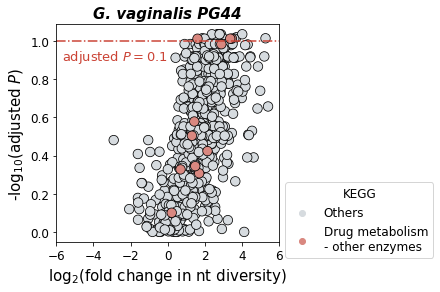

In [146]:
plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.scatterplot(x='fold', y='adjustp', hue='kegg', data=df_kegg, s=90, 
                palette={'others':'#D6DBDF', 'drug':'#D98880'}, edgecolor='black')


handles, labels = ax.get_legend_handles_labels()
labels=['Others', 'Drug metabolism\n- other enzymes']
ax.legend(handles, labels, title='KEGG', fontsize=12, loc='center left', 
          bbox_to_anchor=(1.0, 0.1), )
plt.xlabel("$\log_{2}$(fold change in nt diversity)", size=15)
plt.ylabel("-$\log_{10}$(adjusted $P$)", size=15)

plt.title("G. vaginalis PG44", size=15, style='italic', fontweight='bold')
plt.axhline(y=1, color = '#CB4335', ls='-.')
plt.text(-5.7, 0.9, 'adjusted $P=0.1$', color='#CB4335', fontsize=13)
# plt.ylim(0,1.2)
plt.xlim(-6,6)
plt.savefig('Gvaginalis_function_enri.pdf', bbox_inches='tight', dpi = 300)
plt.show()


## Fig. 3a Correlation between nucleotide diversity and relative abundance of Gardnerella spp.

In [ ]:
# load relative abundance from Atlas outputs
reAbun = pd.read_csv('mag_relative_abundance.csv', index_col=0).dropna(how='all').dropna(axis=1, how='all')
reAbun = reAbun[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]
reAbun_s1, reAbun_s1_sample = select_data_by_week(0, 37, reAbun)

# load nucleotide diversity 
df = pd.read_pickle('subsample_nt.df').T
df.columns = df.columns.str.split('.').str[0]
df = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]
df_s1, df_s1_sample = select_data_by_week(0, 37, df)

# merge two data sets

df_s1_G = df_s1.median(axis=1).to_frame(name = 'nt_div')
reAbun_s1_G = reAbun_s1.median(axis=1).to_frame(name = 'reAbun')
nt_reAbun_s1 = pd.merge(df_s1_G, reAbun_s1_G, left_index=True, right_index=True)

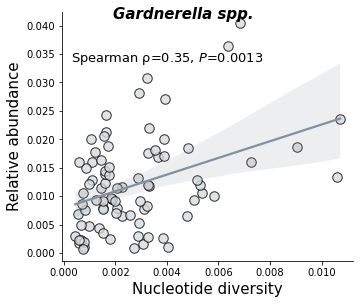

In [6]:
from scipy import stats
plt.rcParams["figure.figsize"] = (4, 4)
slope, intercept, r_value, p_value, std_err = stats.linregress(nt_reAbun_s1['nt_div'],nt_reAbun_s1['reAbun'])

ax = sns.lmplot(x='nt_div', y='reAbun', data=nt_reAbun_s1, scatter_kws = {'s':90, 'color':'#D6DBDF', 'edgecolor': 'black'},
                line_kws = {'color':'#85929E'}, legend=False, height=4.2, aspect=1.2)
ax.fig.suptitle('Gardnerella spp.', size=15, fontweight='bold', style='italic')
r, p = stats.spearmanr(list(nt_reAbun_s1['nt_div']), list(nt_reAbun_s1['reAbun']))
g = plt.gca()
g.text(.03, .8, 'Spearman ρ={:.2f}, $P$={:.2g}'.format(r, p), transform=g.transAxes, fontsize=13, color='black')
# g.text(.05, .8, 'y={0:.4g}x+{1:.4g}'.format(slope,intercept), transform=g.transAxes, fontsize=14, color='#566573')
# ax.set(yscale="log")
plt.xlabel('Nucleotide diversity', size=15)
plt.ylabel('Relative abundance', size=15)
plt.savefig('Gvaginalis_abun_nt_div_corr.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Supplementary Fig. 6 Correlation between nucleotide diversity and relative abundance of non-Gardnerella phylogroups

In [100]:
reAbun = pd.read_csv('mag_relative_abundance.csv', index_col=0).dropna(how='all').dropna(axis=1, how='all')
df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]

reAbun_s1, reAbun_s1_sample = select_data_by_week(0, 37, reAbun)
df_s1, df_s1_sample = select_data_by_week(0, 37, df)

In [102]:
# identify non-Gardnerella phylogroups that have a significant correlation between nt diversity and relative abundance
gv = ['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']
from scipy import stats
corr = {}
for (columnName, columnData) in reAbun_s1.iteritems(): 
    if columnName in df_s1.columns and columnName not in gv:
        nt_reAbun_s1 = pd.merge(reAbun_s1[[columnName]], df_s1[[columnName]], left_index=True, right_index=True)
        nt_reAbun_s1 = nt_reAbun_s1.dropna(thresh=2)
        if len(nt_reAbun_s1) > 5:
            r, p = stats.spearmanr(list(nt_reAbun_s1.iloc[:, 0]), list(nt_reAbun_s1.iloc[:, 1]))
            corr[columnName] = [r, -np.log10(p)]
            print(columnName, r, p)

MAG026 0.0 1.0
MAG038 0.5151515151515151 0.12755286970323426
MAG077 0.04895104895104895 0.8799185788786749
MAG078 0.41208791208791207 0.16175105277252633
MAG080 -0.38836898395721925 0.025517448136885383
MAG086 -0.31886440143067535 0.0014562423969545915
MAG087 0.08571428571428573 0.8717434402332361
MAG095 0.45 0.22421610749233659
MAG113 0.2594375752270489 0.11573634877375187
MAG122 -0.4047619047619048 0.3198886412288162


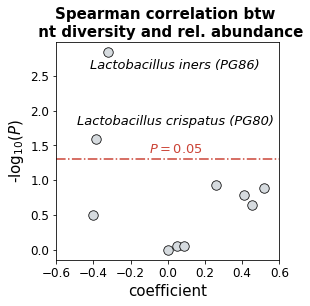

In [103]:
plt.rcParams["figure.figsize"] = (4, 4)

corr_df = pd.DataFrame.from_dict(corr , orient='index', columns=['r', 'p'])
sns.scatterplot(x='r', y='p', data=corr_df, s=90, color='#D6DBDF', edgecolor='black')


plt.xlabel("coefficient", size=15)
plt.ylabel("-$\log_{10}(P)$", size=15)
plt.title("Spearman correlation btw \n nt diversity and rel. abundance", size=15, fontweight='bold')
plt.axhline(y=1.3, color = '#CB4335', ls='-.')
plt.xlim(-0.6,0.6)
plt.text(-0.1, 1.4, '$P=0.05$', color='#CB4335', fontsize=13)
plt.text(-0.49, 1.8, 'Lactobacillus crispatus (PG80)', color='black', fontsize=13, style='italic')
plt.text(-0.42, 2.6, 'Lactobacillus iners (PG86)', color='black', fontsize=13, style='italic')
plt.savefig('nt_reAbun_others.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [ ]:
# L. iners (MAG086)
reAbun = pd.read_csv('mag_relative_abundance.csv', index_col=0).dropna(how='all').dropna(axis=1, how='all')
reAbun = reAbun[['MAG086']]
reAbun_s1, reAbun_s1_sample = select_data_by_week(0, 37, reAbun)

df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]
df = df[['MAG086']]
df_s1, df_s1_sample = select_data_by_week(0, 37, df)

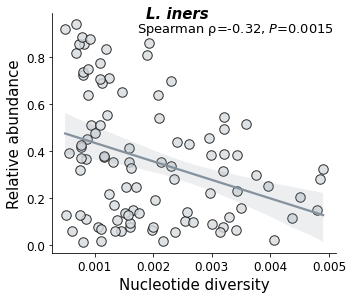

In [14]:
df_s1_G = df_s1.median(axis=1).to_frame(name = 'nt_div')
reAbun_s1_G = reAbun_s1.median(axis=1).to_frame(name = 'reAbun')
nt_reAbun_s1 = pd.merge(df_s1_G, reAbun_s1_G, left_index=True, right_index=True)

plt.rcParams["figure.figsize"] = (4, 4)
slope, intercept, r_value, p_value, std_err = stats.linregress(nt_reAbun_s1['nt_div'],nt_reAbun_s1['reAbun'])

ax = sns.lmplot(x='nt_div', y='reAbun', data=nt_reAbun_s1, scatter_kws = {'s':90, 'color':'#D6DBDF', 'edgecolor': 'black'},
                line_kws = {'color':'#85929E'}, legend=False, height=4.2, aspect=1.2)
ax.fig.suptitle('L. iners', size=15, fontweight='bold', style='italic')
r, p = stats.spearmanr(list(nt_reAbun_s1['nt_div']), list(nt_reAbun_s1['reAbun']))
g = plt.gca()
g.text(0.3, .92, 'Spearman ρ={:.2f}, $P$={:.2g}'.format(r, p), transform=g.transAxes, fontsize=13, color='black')

plt.xlabel('Nucleotide diversity', size=15)
plt.ylabel('Relative abundance', size=15)
plt.savefig('Lactobacillus_iners_nt_div_corr.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [ ]:
# L. crispatus
reAbun = pd.read_csv('mag_relative_abundance.csv', index_col=0).dropna(how='all').dropna(axis=1, how='all')
reAbun = reAbun[['MAG080']]
reAbun_s1, reAbun_s1_sample = select_data_by_week(0, 37, reAbun)

df = pd.read_pickle('nt.df').T
df.columns = df.columns.str.split('.').str[0]
df = df[['MAG080']]
df_s1, df_s1_sample = select_data_by_week(0, 37, df)

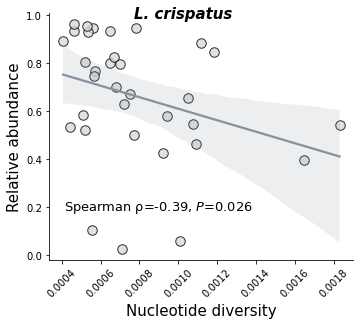

In [8]:
df_s1_G = df_s1.median(axis=1).to_frame(name = 'nt_div')
reAbun_s1_G = reAbun_s1.median(axis=1).to_frame(name = 'reAbun')
nt_reAbun_s1 = pd.merge(df_s1_G, reAbun_s1_G, left_index=True, right_index=True)

plt.rcParams["figure.figsize"] = (4, 4)
slope, intercept, r_value, p_value, std_err = stats.linregress(nt_reAbun_s1['nt_div'],nt_reAbun_s1['reAbun'])

ax = sns.lmplot(x='nt_div', y='reAbun', data=nt_reAbun_s1, scatter_kws = {'s':90, 'color':'#D6DBDF', 'edgecolor': 'black'},
                line_kws = {'color':'#85929E'}, legend=False, height=4.2, aspect=1.2)
ax.fig.suptitle('L. crispatus', size=15, fontweight='bold', style='italic')
r, p = stats.spearmanr(list(nt_reAbun_s1['nt_div']), list(nt_reAbun_s1['reAbun']))
g = plt.gca()
g.text(0.05, .2, 'Spearman ρ={:.2f}, $P$={:.2g}'.format(r, p), transform=g.transAxes, fontsize=13, color='black')
# g.text(.05, .8, 'y={0:.4g}x+{1:.4g}'.format(slope,intercept), transform=g.transAxes, fontsize=14, color='#566573')
# ax.set(yscale="log")
plt.xlabel('Nucleotide diversity', size=15)
plt.xticks(rotation = 45)
plt.ylabel('Relative abundance', size=15)
plt.savefig('Lactobacillus_crispatus_nt_div_corr.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 3b and 3c Growth rate of Gardnerella spp. compared between sPTB and TV for S1 and S2

In [7]:
bins_mag = pd.read_csv('allbins2genome.tsv', sep = '\t', index_col=0)
bins = pd.read_csv('genomic_bins_metabat.tsv', sep = '\t', index_col=0)
df_m = pd.merge(bins_mag, bins, left_index=True, right_index=True) 
gRodon = pd.read_csv('gRodon_results.txt', sep = '\t', index_col=0)
gRodon = gRodon.dropna()

df = pd.merge(gRodon, df_m, left_index=True, right_index=True) 
df = df[['d', 'MAG', 'Sample']]
df = df.rename(columns={'Sample': 'Run'})

df = pd.merge(df, META[['Run', 'subjects', 'group']], on='Run', how='left')

def df_gRodon_wk(k, n, df):
    wk = META[(META['weeks_pregnant'] >= k) & (META['weeks_pregnant'] < k + n)]
    df = df[df['Run'].isin(wk['Run'])]
    return df

def get_gR_group(df):
    ptb_gR = defaultdict(list)
    tb_gR = defaultdict(list) 
    for key in ['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051', 'MAG052', 'MAG053']:
        df_t = df[df['MAG'] == key]
        ptb_sub = defaultdict(list)
        tb_sub = defaultdict(list)
        for index, row in df_t.iterrows():
            if row['group'] == 'PTB':
                ptb_sub[row['subjects']].append(row['d'])
            else:
                tb_sub[row['subjects']].append(row['d'])
        for sub in ptb_sub:
            ptb_gR[sub].append(statistics.median(ptb_sub[sub]))
        for sub in tb_sub:
            tb_gR[sub].append(statistics.median(tb_sub[sub]))

    ptb_ab=[]
    tb_ab=[]
    for ptbi in ptb_gR:
        ptb_ab.append(statistics.median(ptb_gR[ptbi]))
    for tbi in tb_gR:
        tb_ab.append(statistics.median(tb_gR[tbi]))

    return ptb_ab, tb_ab

df_s1 = df_gRodon_wk(0, 20, df)
df_s2 = df_gRodon_wk(20, 17, df)

13 29
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.684e-02 U_stat=1.180e+02


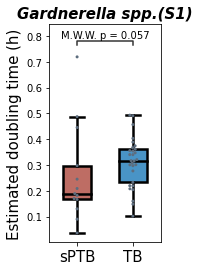

In [8]:
# S1
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab, tb_ab = get_gR_group(df_s1)
print(len(ptb_ab), len(tb_ab))

boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
#             ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                       test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title('Gardnerella spp.(S1)', size=15, fontweight='bold', style='italic')
plt.ylabel('Estimated doubling time (h)', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_sub_gRodon_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

13 41
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.452e-01 U_stat=1.940e+02


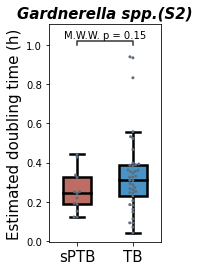

In [9]:
#S2
ptb_ab, tb_ab = get_gR_group(df_s2)
print(len(ptb_ab), len(tb_ab))

boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
#             ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                       test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title('Gardnerella spp.(S2)', size=15, fontweight='bold', style='italic')
plt.ylabel('Estimated doubling time (h)', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_sub_gRodon_s2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Check sequencing bias

## Supplementary Fig. 5a MAG completeness compared between sPTB and TB

ptb v.s. ftb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.074e-01 U_stat=1.019e+05


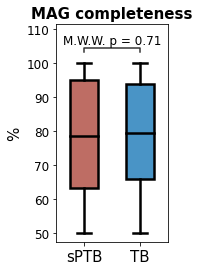

In [229]:
df_m_GAS = pd.read_pickle("mag_sample_meta.pkl")
plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(x='group', y='Completeness', data=df_m_GAS, palette=['#CD6155', '#3498DB'], **boxplot_kwargs)
add_stat_annotation(ax, data=df_m_GAS, x='group', y='Completeness',
                    box_pairs=[('ptb', 'ftb')],
                    test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                   pvalue_format_string="{:.2g}")
ax.set_xticklabels(('sPTB', 'TB'), size=15)
ax.set_title('MAG completeness', size=15, fontweight='bold')
plt.ylabel('%', size=15)
plt.xlabel('')
plt.savefig('MAGs_completeness_comparison.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5b MAG contamination compared between sPTB and TB

ptb v.s. ftb: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.274e-01 U_stat=1.020e+05


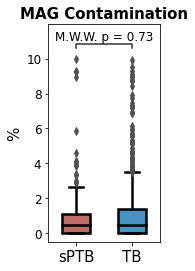

In [230]:
plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(x='group', y='Contamination', data=df_m_GAS, palette=['#CD6155', '#3498DB'], **boxplot_kwargs)
add_stat_annotation(ax, data=df_m_GAS, x='group', y='Contamination',
                    box_pairs=[('ptb', 'ftb')],
                    test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                   pvalue_format_string="{:.2g}")
ax.set_xticklabels(('sPTB', 'TB'), size=15)
ax.set_title('MAG Contamination', size=15, fontweight='bold')
plt.ylabel('%', size=15)
plt.xlabel('')
plt.savefig('MAGs_contamination_comparison.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5c Total reads of samples compared between sPTB and TB

135
570
sPTB v.s. TB: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.432e-04 U_stat=4.595e+04


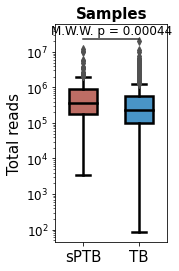

In [44]:
reads = pd.read_csv('total_reads_all.csv', index_col=0)
label=[]
for index, row in reads.iterrows():
    if index in list(sample_ptb['Run']):
        label.append('sPTB')
    elif index in list(sample_tb['Run']):
        label.append('TB')
    else:
        label.append('no')
reads['label'] = label

reads_s = reads[reads['label']!='no']
reads_s = reads_s.sort_values(by=['label'], ascending=False)
print(len(reads_s[reads_s['label']=='sPTB']))
print(len(reads_s[reads_s['label']=='TB']))
plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(x='label', y='Total Sequences', data=reads_s, palette=['#CD6155', '#3498DB'], **boxplot_kwargs)
ax.set_xticklabels(('sPTB', 'TB'), size=15)
ax.set_title('Samples', size=15, fontweight='bold')
ax.set_yscale('log')
add_stat_annotation(ax, data=reads_s, x='label', y='Total Sequences',
                    box_pairs=[('sPTB', 'TB')],
                    test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                   pvalue_format_string="{:.2g}")
plt.ylabel('Total reads', size=15)
plt.xlabel('')
plt.savefig('sample_reads_comparison_all.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5d Total reads of subjects compared between sPTB and TB

175
40
135
sPTB v.s. TB: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.088e-02 U_stat=3.228e+03


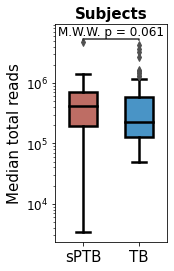

In [104]:
reads = pd.read_csv('total_reads_all.csv', index_col=0)

sub_dict=defaultdict(list)
for key in ptb_dict:
    sub_dict[key] = ptb_dict[key]
for key_ in tb_dict:
    sub_dict[key_] = tb_dict[key_]
    
print(len(sub_dict))
print(len(ptb_dict))
print(len(tb_dict))

sub = {}
for k, l in sub_dict.items():
    tmp = reads[reads.index.isin(l)]
    sub[k] = tmp.median()
sub_df = pd.DataFrame.from_dict(sub, orient='index') 
label=[]
for index, row in sub_df.iterrows():
    if index in list(ptb_dict):
        label.append('sPTB')
    elif index in list(tb_dict):
        label.append('TB')
    else:
        label.append('no')
sub_df['label'] = label

sub_df_s = sub_df[sub_df['label']!='no']

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(x='label', y='Total Sequences', data=sub_df, palette=['#CD6155', '#3498DB'], **boxplot_kwargs)
ax.set_xticklabels(('sPTB', 'TB'), size=15)
ax.set_title('Subjects', size=15, fontweight='bold')
ax.set_yscale('log')
add_stat_annotation(ax, data=sub_df, x='label', y='Total Sequences',
                    box_pairs=[('sPTB', 'TB')],
                    test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                   pvalue_format_string="{:.2g}")
plt.ylabel('Median total reads', size=15)
plt.xlabel('')
plt.savefig('subject_reads_comparison_all.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5f Nucleotide diversity of all phylogroups compared between sPTB and TB based on 10^5 reads sampled from each sample. 

36 128
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.546e-02 U_stat=2.914e+03


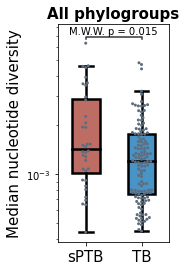

In [40]:
df = pd.read_pickle('subsample_nt.df').T
ptb_ab, tb_ab = ptb_tb_sub_median(df)

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("All phylogroups", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('all_ntdiversity_subject_subsample.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5g Nucleotide diversity of Gardnerella spp. compared between sPTB and TB based on 10^5 reads sampled from each sample. 

25 64
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.335e-03 U_stat=1.113e+03


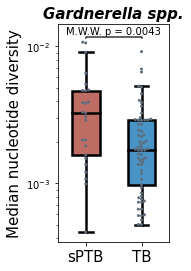

In [53]:
df = pd.read_pickle('subsample_nt.df').T
df.columns = df.columns.str.split('.').str[0]
df_sig = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]
ptb_ab, tb_ab = ptb_tb_sub_median(df_sig)

plt.rcParams["figure.figsize"] = (2, 4)

print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.", size=15, fontweight='bold', style='italic')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_subject_ntdiversity_subsample.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5h and 5i Nucleotide diversity of Gardnerella spp. for S1 and S2 compared between sPTB and TB based on 10^5 reads sampled from each sample. 

In [ ]:
df = pd.read_pickle('subsample_nt.df').T
df.columns = df.columns.str.split('.').str[0]
df = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

15 31
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.601e-02 U_stat=3.280e+02


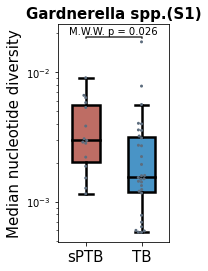

In [55]:
#S1

ptb_ab = []
tb_ab =[]
df = df_s1.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
    
plt.rcParams["figure.figsize"] = (2, 4)

print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.(S1)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_subject_ntdiversity_subsample_S1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

18 48
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.238e-01 U_stat=5.170e+02


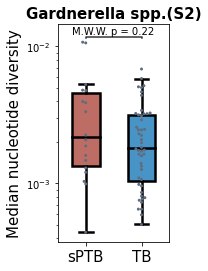

In [56]:
#S2

ptb_ab = []
tb_ab =[]
df = df_s2.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
plt.rcParams["figure.figsize"] = (2, 4)

print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.(S2)", size=15, fontweight='bold')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_subject_ntdiversity_subsample_S2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 5e Spearman correlation between genome-wide nucleotide diversity and reads mapped to each of the four Gardnerella spp. phylogroups 

In [45]:
count = pd.read_csv('mag_raw_counts.csv', index_col=0)
count = count.T
count = count.replace(0, np.nan)
ntdiv = pd.read_pickle('nt.df')
ntdiv = ntdiv.T
ntdiv.columns = ntdiv.columns.str.split('.').str[0]

# spearmann correlation for all Gardnerella spp. phylogroups

gv = ['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']
corr = []
for (columnName, columnData) in count.iteritems():
    if columnName in ntdiv.columns:
        merge = pd.merge(columnData, ntdiv[columnName], left_index=True, right_index=True).dropna(thresh=2)
        if columnName in gv:
            rho, prob = stats.spearmanr(np.log10(list(merge[merge.columns[0]])), list(merge[merge.columns[1]]))
            corr.append(rho)

# median and 25% and 75&

print(np.median(corr))
q3, q1 = np.percentile(corr, [75 ,25])
print(q3, q1)

-0.1910601004671483
-0.0835051332888507 -0.3161690801144959


178


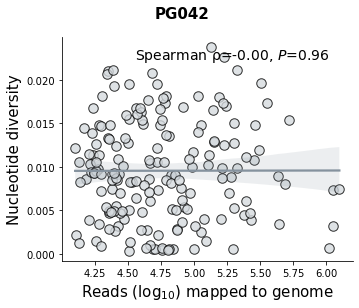

200


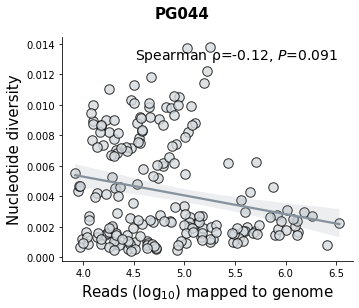

169


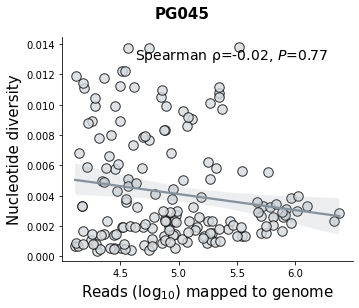

96


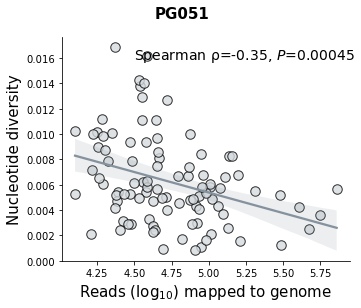

In [46]:
plt.rcParams["figure.figsize"] = (4, 4)

for (columnName, columnData) in count.iteritems():
    if columnName in ['MAG042', 'MAG044', 'MAG045', 'MAG051']:
        merge = pd.merge(columnData, ntdiv[columnName], left_index=True, right_index=True).dropna(thresh=2)
        merge['log10'] = np.log10(list(merge[merge.columns[0]]))
        print(len(merge['log10']))
        ax = sns.lmplot(x=merge.columns[2], y=merge.columns[1], data=merge, scatter_kws = {'s':90, 'color':'#D6DBDF', 'edgecolor': 'black'},
                line_kws = {'color':'#85929E'}, legend=False, height=4.2, aspect=1.2)
        ax.fig.suptitle('PG'+columnName[3:], size=15, fontweight='bold')
        def annotate(data, **kws):
            r, p = stats.spearmanr(list(merge[merge.columns[2]]), list(merge[merge.columns[1]]))
            g = plt.gca()
            g.text(.25, .9, 'Spearman ρ={:.2f}, $P$={:.2g}'.format(r, p), transform=g.transAxes, fontsize=14)
        ax.map_dataframe(annotate)
#         ax.set(xscale="log")
        plt.ylabel('Nucleotide diversity', size=15)
        plt.xlabel('Reads ($\log_{10}$) mapped to genome', size=15)
        plt.savefig(columnName + '_read_ntdiv_cor.pdf', bbox_inches='tight', dpi = 300)
        plt.show()

# Check bias caused by higher number of reads mapped to Gardnerella spp. 

## Supplementary Fig. 5j Nucleotide diversity of Gardnerella spp. compared between sPTB and TB based on 5K Gardnerella spp. reads sampled from each sample. 

33 95
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.817e-02 U_stat=1.958e+03


/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 29.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


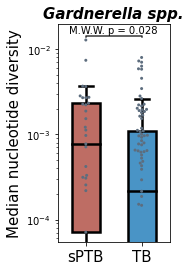

In [57]:
df = pd.read_pickle('5K_nt.df').T
df.columns = df.columns.str.split('.').str[0]
df.index = df.index.str.split('_').str[0]
df_sig = df[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]
ptb_ab, tb_ab = ptb_tb_sub_median(df_sig)

plt.rcParams["figure.figsize"] = (2, 4)
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Gardnerella spp.", size=15, fontweight='bold', style='italic')
plt.ylabel('Median nucleotide diversity', size=15)
plt.xlabel('')
plt.savefig('Gvaginalis_subject_ntdiversity_subsample_Gv.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Recombination

## Fig. 3d and e Recombination in Garnerella spp. compared between sPTB and TB subjects for S1 and S2

In [ ]:
df = pd.read_pickle('d_prime.df').T

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


23 65
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.061e-02 U_stat=1.630e+02


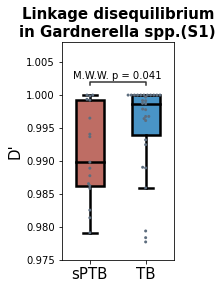

In [11]:
# S1
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df_s1.columns = df_s1.columns.str.split('.').str[0]
df_s1 = df_s1[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]

df = df_s1.median(axis=1)

for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))

print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Linkage disequilibrium\nin Gardnerella spp.(S1)", size=15, fontweight='bold')
plt.ylabel("D'", size=15)
plt.xlabel('')
plt.ylim(0.975, 1.008)
plt.savefig('Gvaginalis_Dprime_sub_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


31 85
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.339e-02 U_stat=2.150e+02


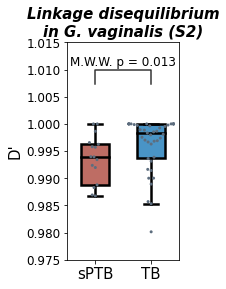

In [16]:
# S2
plt.rcParams["figure.figsize"] = (2, 4)
ptb_ab = []
tb_ab =[]
df_s2.columns = df_s2.columns.str.split('.').str[0]
df_s2 = df_s2[['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']]

df = df_s2.median(axis=1)

for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)

ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("Linkage disequilibrium\nin G. vaginalis (S2)", size=15, fontweight='bold', style='italic')
plt.ylabel("D'", size=15)
plt.xlabel('')
plt.ylim(0.975, 1.015)
plt.savefig('Gvaginalis_Dprime_sub_s2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 7a Recombination in Garnerella spp. phylogroups compared between sPTB and TB subjects for S1

note: none is significant for S2

In [12]:
pvalue = {}
for (columnName, columnData) in df_s1.iteritems(): 
    ptb_ab = []
    tb_ab = []
    for index, row in df_s1.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='two-sided')
    pvalue[columnName] = prob
df_sig = df_s1[fdr_sig(pvalue)]

FDR MAG042 0.08828917311988271
FDR MAG046 0.08828917311988271
FDR MAG047 0.08828917311988271


14 24
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.207e-02 U_stat=9.200e+01


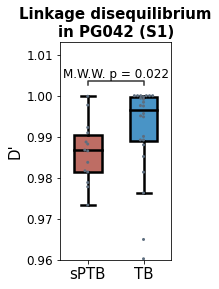

11 15
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.693e-02 U_stat=3.600e+01


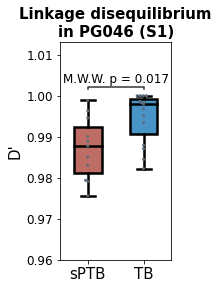

11 13
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.273e-02 U_stat=2.800e+01


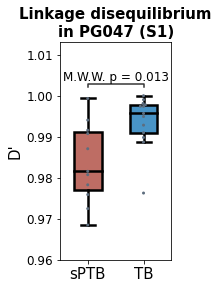

In [18]:
for (columnName, columnData) in df_sig.iteritems(): 
    ptb_ab = []
    tb_ab = []
    for index, row in df_sig.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    if len(ptb_ab) != 0 and len(tb_ab) != 0:
        print(len(ptb_ab), len(tb_ab))
        boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
        lineprops = {'color': 'k', 'linewidth': 2.5}
        boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
        ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
#             ax.set_yscale('log')
        ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
        test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                          pvalue_format_string="{:.2g}")
        ax.set_xticklabels(['sPTB', 'TB'], size=15)
        ax.set_title('Linkage disequilibrium\nin PG' + columnName[3:] + ' (S1)', size=15, fontweight='bold')
        plt.ylabel("D'", size=15)
        plt.xlabel('')
        plt.ylim(0.96, 1.013)
        plt.savefig(columnName + '_Dprime_S1.pdf', bbox_inches='tight', dpi = 300)
        plt.show()

# Selection

In [ ]:
df = pd.read_pickle('dnds_gene_mag_cog_median.df')
cog_sample_dic = {}
for index, row in df.iterrows():
    cog_phy = defaultdict(list)
    for (columnName, columnData) in df.iteritems():
        if columnName.split('_')[0] in ['MAG042', 'MAG043','MAG044','MAG045','MAG046','MAG047','MAG048','MAG049','MAG050','MAG051','MAG052', 'MAG053']:
            if str(row[columnName]) != 'nan':
                cog_phy[columnName.split('_')[1]].append(row[columnName])
    cog_dic = {}
    for key in cog_phy:
        cog_dic[key] = statistics.median(cog_phy[key])
    cog_sample_dic[index] = cog_dic
df_cog_sample = pd.DataFrame(cog_sample_dic).T.dropna(how='all')
df_cog_sample = df_cog_sample.dropna(axis=1, how='all')

df_s1, df_s1_sample = select_data_by_week(0, 20, df_cog_sample)
df_s2, df_s2_sample = select_data_by_week(20, 17, df_cog_sample)

## Supplementary Fig. 7c Selection in COG functional category of Garnerella spp.  compared between sPTB and TB subjects for S1

In [18]:
# fdr correction
cog_lb = []
value = []
label = []
pvalue = {}
for (columnName, columnData) in df_s1.iteritems():
    ptb_ab = []
    tb_ab = []
    for index, raw in df_s1.iterrows():
        if str(raw[columnName])!= 'nan':
            if index in ptb_dict:
                label.append('sPTB')
                cog_lb.append(columnName)
                value.append(raw[columnName])
                ptb_ab.append(raw[columnName])
            else:
                label.append('TB')
                cog_lb.append(columnName)
                value.append(raw[columnName])
                tb_ab.append(raw[columnName])
    u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='two-sided')
    pvalue[columnName] = prob
        
fdr_sig(pvalue)       

[]

Index(['J', 'F', 'O', 'G', 'H', 'C', 'K', 'E', 'P', 'N', 'I', 'T', 'U', 'L',
       'V', 'Q', 'D', 'M', 'S'],
      dtype='object', name='type')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

I_sPTB v.s. I_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=1.457e-02 U_stat=2.050e+02
U_sPTB v.s. U_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=6.379e-01 U_stat=3.010e+02
M_sPTB v.s. M_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=4.564e-02 U_stat=2.310e+02
T_sPTB v.s. T_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=6.083e-01 U_stat=3.180e+02
L_sPTB v.s. L_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=4.151e-01 U_stat=3.190e+02
V_sPTB v.s. V_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=5.218e-01 U_stat=3.105e+02
Q_sPTB v.s. Q_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=4.446e-02 U_stat=1.775e+02
D_sPTB v.s. D_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=3.135e

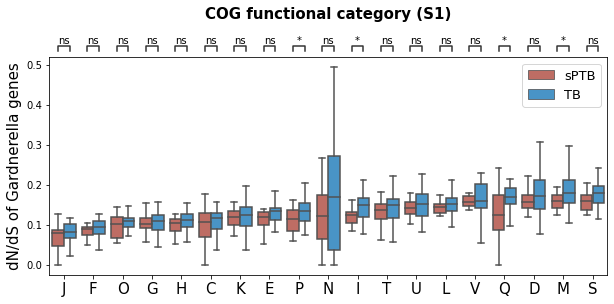

In [19]:
cog_dic = {'type': cog_lb, 'val': value, 'label': label} 
cog_df = pd.DataFrame(cog_dic)
cog_df = cog_df.sort_values(by='label', ascending=False)

grouped = cog_df.loc[:,['type', 'val']].groupby(['type']).median().sort_values(by='val')
print(grouped.index)
plt.rcParams["figure.figsize"] = (10,4)
ax = sns.boxplot(x='type', y='val', hue='label', data=cog_df, palette=['#CD6155', '#3498DB'], showfliers=False, order=grouped.index)
add_stat_annotation(ax, x='type', y='val', hue='label', data=cog_df, order=grouped.index,
                    box_pairs=[(('I', 'TB'), ('I', 'sPTB')),
                               (('P', 'TB'), ('P', 'sPTB')),
                               (('H', 'TB'), ('H', "sPTB")),
                               (('U', 'TB'), ('U', "sPTB")),
                               (('M', 'TB'), ('M', 'sPTB')),
                               (('T', 'TB'), ('T', "sPTB")),
                               (('J', 'TB'), ('J', 'sPTB')),
                               (('C', 'TB'), ('C', 'sPTB')),
                               (('O', 'TB'), ('O', "sPTB")),
                               (('F', 'TB'), ('F', "sPTB")),
                               (('L', 'TB'), ('L', 'sPTB')),
                               (('K', 'TB'), ('K', "sPTB")),
                               (('E', 'TB'), ('E', 'sPTB')),
                               (('G', 'TB'), ('G', 'sPTB')),
                               (('V', 'TB'), ('V', "sPTB")),
                               (('Q', 'TB'), ('Q', "sPTB")),
                               (('D', 'TB'), ('D', 'sPTB')),
                               (('N', 'TB'), ('N', "sPTB")),
                               (('S', 'TB'), ('S', 'sPTB'))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction=None, verbose=2)

plt.title("COG functional category (S1)", size=15, fontweight='bold', y=1.15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel("dN/dS of Gardnerella genes", size=15)
plt.xticks(size=15)
plt.legend(title="", fontsize=13)
plt.savefig('dnds_COG_Gv_S1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 3f Selection in COG functional category of Garnerella spp.  compared between sPTB and TB subjects for S2

In [20]:
# fdr correction
cog_lb = []
value = []
label = []
pvalue = {}
for (columnName, columnData) in df_s2.iteritems():
    ptb_ab = []
    tb_ab = []
    for index, raw in df_s2.iterrows():
        if str(raw[columnName])!= 'nan':
            if index in ptb_dict:
                label.append('sPTB')
                cog_lb.append(columnName)
                value.append(raw[columnName])
                ptb_ab.append(raw[columnName])
            else:
                label.append('TB')
                cog_lb.append(columnName)
                value.append(raw[columnName])
                tb_ab.append(raw[columnName])
    u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='two-sided')
    pvalue[columnName] = prob

fdr_sig(pvalue)       

FDR I 0.07663858728447545


['I']

Index(['J', 'F', 'O', 'G', 'H', 'C', 'E', 'P', 'K', 'T', 'I', 'U', 'L', 'Q',
       'N', 'M', 'S', 'D', 'V'],
      dtype='object', name='type')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

I_sPTB v.s. I_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=4.034e-03 U_stat=3.845e+02
U_sPTB v.s. U_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=9.134e-01 U_stat=6.040e+02
M_sPTB v.s. M_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=9.124e-01 U_stat=6.780e+02
T_sPTB v.s. T_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=9.512e-01 U_stat=6.150e+02
L_sPTB v.s. L_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=1.456e-01 U_stat=5.370e+02
V_sPTB v.s. V_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=7.832e-01 U_stat=6.180e+02
Q_sPTB v.s. Q_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=5.314e-01 U_stat=5.270e+02
D_sPTB v.s. D_TB: Mann-Whitney-Wilcoxon test two-sided, P_val=3.836e

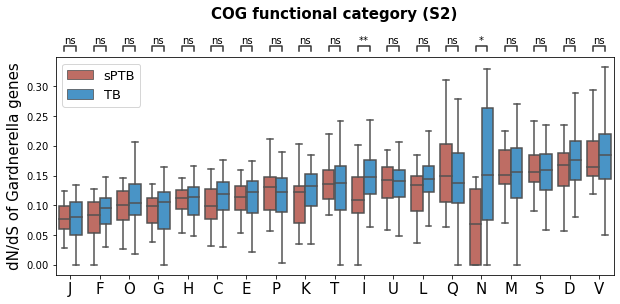

In [21]:
cog_dic = {'type': cog_lb, 'val': value, 'label': label} 
cog_df = pd.DataFrame(cog_dic)
cog_df = cog_df.sort_values(by='label', ascending=False)

grouped = cog_df.loc[:,['type', 'val']].groupby(['type']).median().sort_values(by='val')
print(grouped.index)
plt.rcParams["figure.figsize"] = (10,4)
ax = sns.boxplot(x='type', y='val', hue='label', data=cog_df, palette=['#CD6155', '#3498DB'], showfliers=False, order=grouped.index)
add_stat_annotation(ax, x='type', y='val', hue='label', data=cog_df, order=grouped.index,
                    box_pairs=[(('I', 'TB'), ('I', 'sPTB')),
                               (('P', 'TB'), ('P', 'sPTB')),
                               (('H', 'TB'), ('H', "sPTB")),
                               (('U', 'TB'), ('U', "sPTB")),
                               (('M', 'TB'), ('M', 'sPTB')),
                               (('T', 'TB'), ('T', "sPTB")),
                               (('J', 'TB'), ('J', 'sPTB')),
                               (('C', 'TB'), ('C', 'sPTB')),
                               (('O', 'TB'), ('O', "sPTB")),
                               (('F', 'TB'), ('F', "sPTB")),
                               (('L', 'TB'), ('L', 'sPTB')),
                               (('K', 'TB'), ('K', "sPTB")),
                               (('E', 'TB'), ('E', 'sPTB')),
                               (('G', 'TB'), ('G', 'sPTB')),
                               (('V', 'TB'), ('V', "sPTB")),
                               (('Q', 'TB'), ('Q', "sPTB")),
                               (('D', 'TB'), ('D', 'sPTB')),
                               (('N', 'TB'), ('N', "sPTB")),
                               (('S', 'TB'), ('S', 'sPTB'))],
                    test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction=None, verbose=2)

plt.title("COG functional category (S2)", size=15, fontweight='bold', y=1.15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel("dN/dS of Gardnerella genes", size=15)
plt.xticks(size=15)
plt.legend(title="", fontsize=13)
plt.savefig('dnds_COG_Gv_S2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 7b Density of median (along pregnancy) of dN/dS of genes in sPTB  and in TB 

234756 621249


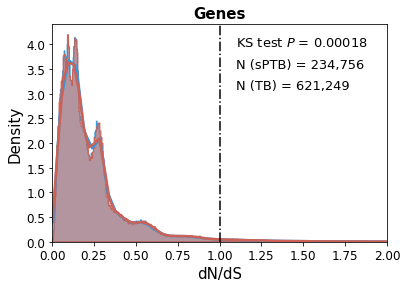

In [44]:
plt.rcParams["figure.figsize"] = (6, 4)
df = pd.read_pickle('dnds_subject_median.df').dropna(axis=1, how='all')
ptb_ab = []
tb_ab = []
for index, row in df.iterrows():
    if index in ptb_dict:
        ptb_ab.extend(row.tolist())
    else:
        tb_ab.extend(row.tolist())
ptb_ab = [x for x in ptb_ab if str(x) != 'nan' and x!=0]
tb_ab = [x for x in tb_ab if str(x) != 'nan' and x!=0]
print(len(ptb_ab), len(tb_ab))
ax = sns.histplot(x=tb_ab, element='step', color='#3498DB', kde=True, line_kws={'linewidth':2.5}, stat='density')
ax = sns.histplot(x=ptb_ab, element='step', color='#CD6155', kde=True, line_kws={'linewidth':2.5}, stat='density')
pval = "%.2g" % stats.ks_2samp(ptb_ab, tb_ab)[1]
ax.text(0.55, 0.9, 'KS test $P$ = ' + pval, transform = ax.transAxes, fontsize=13)
ax.text(0.55, 0.8, 'N (sPTB) = 234,756', transform = ax.transAxes, fontsize=13)
ax.text(0.55, 0.7, 'N (TB) = 621,249', transform = ax.transAxes, fontsize=13)
plt.axvline(x=1, color = 'black', ls='-.')
plt.xlabel("dN/dS", size = 15)
plt.ylabel("Density", size=15)
plt.xlim([0,2])
plt.title('Genes', size=15, fontweight='bold')
plt.savefig('dnds_hist.pdf', bbox_inches='tight', dpi = 300)
plt.show()

In [57]:
print(np.median(ptb_ab + tb_ab))
q3, q1 = np.percentile(ptb_ab + tb_ab, [75 ,25])
print(q3, q1)

0.17170479302832253
0.2913043478260869 0.0997566909975664


# AMR

# Subsampling identifcal number of reads and compared reads mapped to AMR

In [76]:
df = pd.read_csv('counts.txt', sep="\t", index_col=0)
df = df.drop('length', axis = 1) 
df.columns = df.columns.str.split('.').str[0]
df = df.T
df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17,df)

## Fig. 4a and b Total reads mapped to AMR genes compared between sPTB and TB for S1 and S2

24 80
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.460e-02 U_stat=1.277e+03


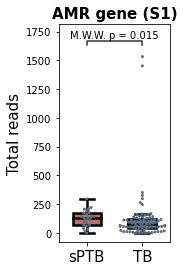

In [79]:
ptb_ab = []
tb_ab =[]

df = df_s1.sum(axis=1)

for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("AMR gene (S1)", size=15, fontweight='bold')
plt.ylabel("Total reads", size=15)
plt.xlabel('')
plt.savefig('AMR_subsample_read_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

36 102
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.563e-01 U_stat=1.900e+03


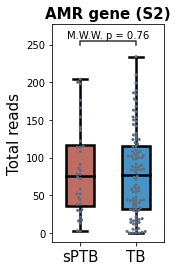

In [80]:
ptb_ab = []
tb_ab =[]

df = df_s2.sum(axis=1)

for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title("AMR gene (S2)", size=15, fontweight='bold')
plt.ylabel("Total reads", size=15)
plt.xlabel('')
plt.savefig('AMR_subsample_read_s2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Pathofact

## Fig. 4c and d AMR gene count compared between sPTB and TB for S1 and S2

In [79]:
df = pd.read_csv('AMR_count.csv', index_col=0)

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

25 85
13.0 6.0
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.133e-02 U_stat=1.418e+03


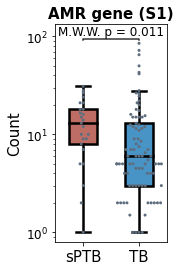

In [171]:
ptb_ab = []
tb_ab =[]
df = df_s1.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))
        
print(len(ptb_ab), len(tb_ab))
print(statistics.median(ptb_ab), statistics.median(tb_ab))

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title('AMR gene (S1)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

36 111
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.601e-01 U_stat=2.310e+03


/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


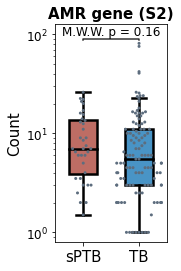

In [121]:
ptb_ab = []
tb_ab =[]
df = df_s2.median(axis=1)
for sub in df.keys():
    if sub in ptb_dict:
        ptb_ab.append(df.get(sub))
    else:
        tb_ab.append(df.get(sub))

print(len(ptb_ab), len(tb_ab))

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title('AMR gene (S2)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s2.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 4e and f AMR gene diversity compared between sPTB and TB for S1 and S2

In [82]:
amr_sum = pd.read_csv('AMR_sum.csv', index_col=0)
amr_sum
ARG = pd.crosstab(amr_sum['sample'], amr_sum['ARG']).T
ARG_rev = ARG / ARG.sum()
ARG_rev = ARG_rev.T

diver={}
for index, row in ARG_rev.iterrows():
    shan = ep.diversity(np.array([row]), 'shannon')
    diver[index]=[shan[0]]
diver_df = pd.DataFrame.from_dict(diver, orient='index', columns=['Diversity'])

df_s1, df_s1_sample = select_data_by_week(0, 20, diver_df)
df_s2, df_s2_sample = select_data_by_week(20, 17, diver_df)

25 85
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.830e-03 U_stat=1.436e+03


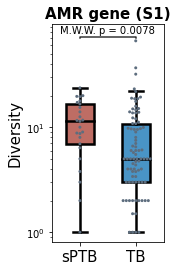

In [83]:
df = df_s1

for (columnName, columnData) in df.iteritems(): 
    ptb_ab = []
    tb_ab =[]
    for index, row in df.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])

print(len(ptb_ab), len(tb_ab))

plt.rcParams["figure.figsize"] = (2, 4)
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax.set_yscale('log')
ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                               test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['sPTB', 'TB'], size=15)
ax.set_title('AMR gene (S1)', size=15, fontweight='bold')
plt.ylabel(columnName, size=15)
plt.xlabel('')
plt.savefig(columnName + '_AMRgene_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

36 111
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.603e-01 U_stat=2.310e+03


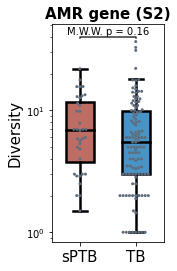

In [84]:
plt.rcParams["figure.figsize"] = (2, 4)

df = df_s2

for (columnName, columnData) in df.iteritems(): 
    ptb_ab = []
    tb_ab =[]
    for index, row in df.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    if len(ptb_ab) != 0 and len(tb_ab) != 0:
        print(len(ptb_ab), len(tb_ab))
        boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
        lineprops = {'color': 'k', 'linewidth': 2.5}
        boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
        ax = sns.boxplot(data=[ptb_ab, tb_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
        ax.set_yscale('log')
        ax = sns.swarmplot(data=[ptb_ab, tb_ab], color="#5D6D7E", size=3)
        test_results = add_stat_annotation(ax, data=[ptb_ab, tb_ab], box_pairs=[(0, 1)],
                                       test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                          pvalue_format_string="{:.2g}")
        ax.set_xticklabels(['sPTB', 'TB'], size=15)
        ax.set_title('AMR gene (S2)', size=15, fontweight='bold')
        plt.ylabel(columnName, size=15)
        plt.xlabel('')
        plt.savefig(columnName + '_AMRgene_s2.pdf', bbox_inches='tight', dpi = 300)
        plt.show()

## Fig. 4g Fraction of AMR genes by location compared between sPTB and TB for S1

In [31]:
amr_sum = pd.read_csv('AMR_sum.csv', index_col=0)
mge = defaultdict(list)
for index, row in amr_sum.iterrows():
    mge[row['sample']].append(row['MGE_prediction'])

mge_dic = {}
for key in mge:
    c = Counter(mge[key])
    mge_dic[key]=pd.Series(c)
mge_df = pd.DataFrame.from_dict(mge_dic, orient='index') 
mge_df=mge_df.fillna(0)
mge_df=mge_df.T
mge_df_per = mge_df / mge_df.sum()
mge_df_per = mge_df_per.T
mge_df_per

df_s1, df_s1_sample = select_data_by_week(0, 20, mge_df_per)
df_s2, df_s2_sample = select_data_by_week(20, 17, mge_df_per)

In [32]:
# perform one-sided mannwhitney test with hypothesis that fraction is higher in PTB than TB
pval = {}

for (columnName, columnData) in df_s1.iteritems(): 
    ptb_ab=[]
    tb_ab=[]
    for index, row in df_s1.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='greater')
    pval[columnName] = prob
    if prob < 0.05:
        print(columnName, prob)

fdr_sig(pval)

ambiguous (plasmid/phage) 0.034641323961071134
phage 0.015461577969284103
FDR phage 0.09276946781570462


['phage']

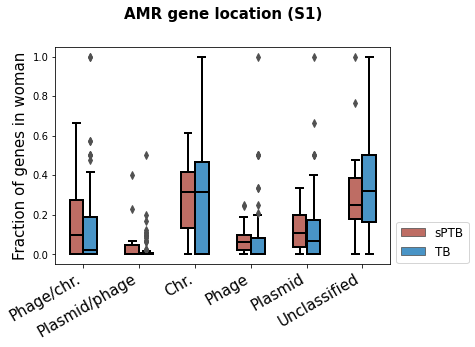

In [33]:
mge_sub_df = df_s1[['chromosome', 'plasmid', 'phage', 'ambiguous (phage/chromosome)', 'ambiguous (plasmid/phage)', 'unclassified']]
mge_sub_new = mge_sub_df.stack().rename_axis(('subject', 'type')).reset_index(name='val')

label=[]
for index, row in mge_sub_new.iterrows():
    if row['subject'] in list(ptb_dict):
        label.append('sPTB')
    else:
        label.append('TB')
mge_sub_new['label'] = label
mge_sub_new = mge_sub_new.sort_values(by=['label', 'type'],ascending=[False, True])


plt.rcParams["figure.figsize"] = (6,4)
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(x='type', y='val', hue='label', data=mge_sub_new, palette=['#CD6155', '#3498DB'],**boxplot_kwargs)
ax.set_xticklabels(('Phage/chr.', 'Plasmid/phage', 'Chr.', 'Phage', 'Plasmid', 'Unclassified'))
plt.title("AMR gene location (S1)", size=15, fontweight='bold', y=1.1)
plt.suptitle('')
plt.xlabel('')
plt.ylabel("Fraction of genes in woman", size=15)
plt.xticks(rotation = 30, size=15, ha='right')
plt.legend(title="", fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.1))
plt.savefig('AMR_location_boxplot_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 4h Fraction of AMR genes by category compared between sPTB and TB for S1

In [34]:
amr_sum = pd.read_csv('AMR_sum.csv', index_col=0)
mge = defaultdict(list)
for index, row in amr_sum.iterrows():
    mge[row['sample']].append(row['AMR_category'])
mge_dic = {}
for key in mge:
    c = Counter(mge[key])
    mge_dic[key]=pd.Series(c)
mge_df = pd.DataFrame.from_dict(mge_dic, orient='index') 
mge_df=mge_df.fillna(0)
mge_df=mge_df.T
mge_df_per = mge_df / mge_df.sum()
mge_df_per = mge_df_per.T
mge_df_per 

df_s1, df_s1_sample = select_data_by_week(0, 20, mge_df_per)
df_s2, df_s2_sample = select_data_by_week(20, 17, mge_df_per)

In [35]:
# perform one-sided mannwhitney test with hypothesis that fraction is higher in PTB than TB
df_s1 = df_s1[['multidrug', 'tetracycline', 'beta-lactam', 'MLS', 'glycopeptide', 'aminoglycoside', 'fluoroquinolone', 'peptide', 'phenicol']]
pval = {}

for (columnName, columnData) in df_s1.iteritems(): 
    ptb_ab=[]
    tb_ab=[]
    for index, row in df_s1.iterrows():
        if str(row[columnName]) != 'nan':
            if index in ptb_dict:
                ptb_ab.append(row[columnName])
            else:
                tb_ab.append(row[columnName])
    if set(ptb_ab) != set(tb_ab):
        u, prob = mannwhitneyu(ptb_ab, tb_ab, alternative='greater')
        pval[columnName] = prob
        if prob < 0.05:
            print(columnName, prob)

fdr_sig(pval)

MLS 0.04191294939456536
glycopeptide 0.03054437827533149
aminoglycoside 0.022420594716074986
phenicol 0.002666260911621825
FDR MLS 0.09430413613777205
FDR glycopeptide 0.09163313482599447
FDR aminoglycoside 0.09163313482599447
FDR peptide 0.09593778185381859
FDR phenicol 0.023996348204596427


['MLS', 'glycopeptide', 'aminoglycoside', 'peptide', 'phenicol']

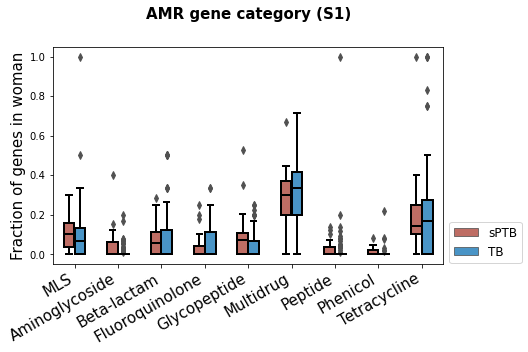

In [36]:
mge_sub_new = df_s1.stack().rename_axis(('subject', 'type')).reset_index(name='val')
mge_sub_new
label=[]
for index, row in mge_sub_new.iterrows():
    if row['subject'] in list(ptb_dict):
        label.append('sPTB')
    else:
        label.append('TB')
mge_sub_new['label'] = label

antibio = ['multidrug', 'tetracycline', 'beta-lactam', 'MLS', 'glycopeptide', 'aminoglycoside', 'fluoroquinolone', 'peptide', 'phenicol']
mge_sub_new = mge_sub_new[mge_sub_new['type'].isin(antibio)]
mge_sub_new = mge_sub_new.sort_values(by=['label', 'type'],ascending=[False, True])

plt.rcParams["figure.figsize"] = (7,4)
from statannot import add_stat_annotation
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})

ax = sns.boxplot(x='type', y='val', hue='label', data=mge_sub_new, palette=['#CD6155', '#3498DB'],**boxplot_kwargs)
ax.set_xticklabels(('MLS', 'Aminoglycoside', 'Beta-lactam', 'Fluoroquinolone', 'Glycopeptide', 'Multidrug', 'Peptide', 'Phenicol', 'Tetracycline'))
plt.title("AMR gene category (S1)", size=15, fontweight='bold', y=1.1)
plt.suptitle('')
plt.xlabel("")
plt.ylabel("Fraction of genes in woman", size=15)
plt.xticks(rotation = 30, size=15, ha='right')
plt.legend(title="", fontsize=12, loc='center left', bbox_to_anchor=(1.0, 0.1))

plt.savefig('AMR_type_boxplot_s1.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Fig. 4i AMR gene count compared between women use drug vs not

In [85]:
df_his = pd.read_pickle("health_history_mrg.df") # load health history data
meta = pd.read_csv("basic_meta.csv")
meta = meta.set_index('Sample_Name')
df_his_merge = pd.merge(df_his, meta, left_index=True, right_index=True)

df_his_use = df_his_merge[df_his_merge['group'] != 'OTHER']
df_his_use = df_his_use.set_index('subjects')
drug = df_his_use[['cephalosporins', 'macrolides', 'metronidazole', 'nitrofurantoin', 'penicillin', 'quinolones', 'sulfa_antibiotics', 'tetracyclines', 'other_antibiotics']] 

In [86]:
drug_comb = {}
for index, row in drug.iterrows():
    if 'Yes' in list(row):
        drug_comb[index] = 'Yes'
    else:
        drug_comb[index] = 'No'

drug_comb_df = pd.DataFrame.from_dict(drug_comb, orient='index',columns=['drug_comb'])

meta = META[['subjects', 'group']].drop_duplicates().set_index('subjects')
drug_comb_meta =  pd.merge(drug_comb_df, meta, left_index=True, right_index=True) 
print(drug_comb_meta.groupby(['group', 'drug_comb']).size())
    
df = pd.read_csv('AMR_count.csv', index_col=0)
df_s1, df_s1_sample = select_data_by_week(0, 20, df)

group  drug_comb
PTB    No            25
       Yes           11
TB     No           100
       Yes           30
dtype: int64


29 80
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.930e-02 U_stat=1.416e+03


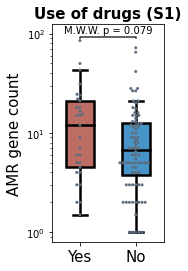

In [89]:
plt.rcParams["figure.figsize"] = (2, 4)

for (columnName, columnData) in drug_comb_df.iteritems(): 
    yes = []
    no = []
    for index, row in drug_comb_df.iterrows():
        if index in df_s1.index:
            if row[columnName] == 'Yes':
                yes.append(df_s1.at[index,'count'])
            if row[columnName] == 'No':
                no.append(df_s1.at[index,'count'])
    u, prob = mannwhitneyu(yes, no, alternative='two-sided')
    if prob < 0.1:
        print(len(yes), len(no))
        boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
        lineprops = {'color': 'k', 'linewidth': 2.5}
        boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
        ax = sns.boxplot(data=[yes, no], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
        ax.set_yscale('log')
        ax = sns.swarmplot(data=[yes, no], color="#5D6D7E", size=3)
        test_results = add_stat_annotation(ax, data=[yes, no], box_pairs=[(0, 1)],
                                       test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                          pvalue_format_string="{:.2g}")
        ax.set_xticklabels(['Yes', 'No'], size=15)
        ax.set_title('Use of drugs (S1)', size=15, fontweight='bold')
        plt.ylabel('AMR gene count', size=15)
        plt.xlabel('')
        plt.savefig('drug_use_AMRgene_s1.pdf', bbox_inches='tight', dpi = 300)
        plt.show()

# Check potential confounding effect by BV

In [88]:
df_his = pd.read_pickle("health_history_mrg.df")
meta = pd.read_csv("basic_meta.csv")
meta = meta.set_index('Sample_Name')
df_his_merge = pd.merge(df_his, meta, left_index=True, right_index=True)

df_his_use = df_his_merge[df_his_merge['group'] != 'OTHER']
df_his_use = df_his_use.set_index('subjects')

In [79]:
df = pd.read_csv('AMR_count.csv', index_col=0)

df_s1, df_s1_sample = select_data_by_week(0, 20, df)
df_s2, df_s2_sample = select_data_by_week(20, 17, df)

## Supplementary Fig. 8a AMR gene count compared between women with and without BV

14 89
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.805e-01 U_stat=5.315e+02


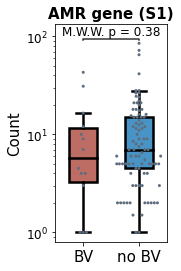

In [84]:
df_s1_bv = pd.merge(df_his_use[['bv']], df_s1, left_index = True, right_index = True)

bv_pre = list(df_s1_bv[df_s1_bv['bv']=='Yes']['count'])

bv_ab = list(df_s1_bv[df_s1_bv['bv']=='No']['count'])

print(len(bv_pre), len(bv_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[bv_pre, bv_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[bv_pre, bv_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[bv_pre, bv_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['BV', 'no BV'], size=15)
ax.set_title('AMR gene (S1)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s1_bv.pdf', bbox_inches='tight', dpi = 300)
plt.show()

20 112
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.046e-01 U_stat=1.014e+03


/ifs/home/tk2829_gp/jl5897/micromamba/envs/python36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


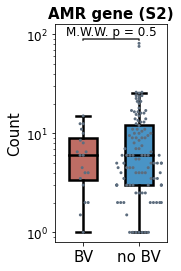

In [83]:
df_s2_bv = pd.merge(df_his_use[['bv']], df_s2, left_index = True, right_index = True)
bv_pre = list(df_s2_bv[df_s2_bv['bv']=='Yes']['count'])
bv_ab = list(df_s2_bv[df_s2_bv['bv']=='No']['count'])

print(len(bv_pre), len(bv_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[bv_pre, bv_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[bv_pre, bv_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[bv_pre, bv_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['BV', 'no BV'], size=15)
ax.set_title('AMR gene (S2)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s2_bv.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Fig. 8b AMR gene count compared between women with and without BV history

22 64
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.541e-01 U_stat=6.280e+02


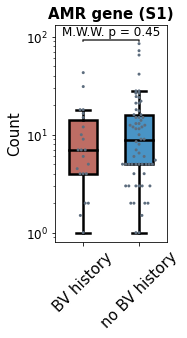

In [86]:
df_s1_bv = pd.merge(df_his_use[['bv_history']], df_s1, left_index = True, right_index = True)

bv_pre = list(df_s1_bv[df_s1_bv['bv_history']=='Yes']['count'])

bv_ab = list(df_s1_bv[df_s1_bv['bv_history']=='No']['count'])

print(len(bv_pre), len(bv_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[bv_pre, bv_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[bv_pre, bv_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[bv_pre, bv_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['BV history', 'no BV history'], size=15, rotation=45)
ax.set_title('AMR gene (S1)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s1_bv_his.pdf', bbox_inches='tight', dpi = 300)
plt.show()

29 81
0 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.037e-01 U_stat=9.345e+02


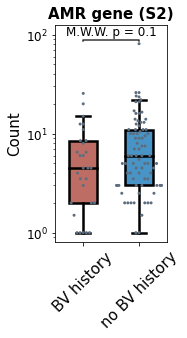

In [87]:
df_s2_bv = pd.merge(df_his_use[['bv_history']], df_s2, left_index = True, right_index = True)

bv_pre = list(df_s2_bv[df_s2_bv['bv_history']=='Yes']['count'])

bv_ab = list(df_s2_bv[df_s2_bv['bv_history']=='No']['count'])

print(len(bv_pre), len(bv_ab))
boxprops = {'edgecolor': 'k', 'linewidth': 2.5}
lineprops = {'color': 'k', 'linewidth': 2.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
               'whiskerprops': lineprops, 'capprops': lineprops,'width': 0.5})
ax = sns.boxplot(data=[bv_pre, bv_ab], palette=['#CD6155', '#3498DB'], **boxplot_kwargs, showfliers=False)
ax = sns.swarmplot(data=[bv_pre, bv_ab], color="#5D6D7E", size=3)
ax.set_yscale('log')
test_results = add_stat_annotation(ax, data=[bv_pre, bv_ab], box_pairs=[(0, 1)],
                                   test='Mann-Whitney', text_format='full', loc='inside', verbose=2,
                                  pvalue_format_string="{:.2g}")
ax.set_xticklabels(['BV history', 'no BV history'], size=15, rotation=45)
ax.set_title('AMR gene (S2)', size = 15, fontweight='bold')
plt.ylabel("Count", size = 15)
plt.xlabel('')
plt.savefig('AMR_count_s2_bv_his.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Sample summary

## Supplementary Fig. 9a Distribution of samples

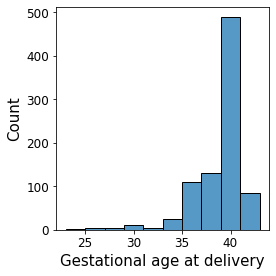

In [11]:
plt.rcParams['figure.figsize'] = 4, 4
META = pd.read_csv("basic_meta.csv")
META['GAD_int'] = META[META['GAD'].notna()]['GAD'].astype(
    str).str[:2].astype(int)

min(META['GAD_int'])


sns.histplot(data=META, x='GAD_int', binwidth=2)
plt.title('', size=15, fontweight='bold')
plt.ylabel('Count', size=15)
plt.xlabel('Gestational age at delivery', size=15)
plt.tight_layout()
plt.savefig('GAD_hist.pdf', bbox_inches='tight', dpi = 300)
plt.show()

## Supplementary Table 2 Summary of longitudinal samples collected for women who deliver spontaneous preterm (sPTB) and at term (TB) during pregnancy.

In [24]:
PTB = META[META['group'] == 'PTB']

In [25]:
print('mean N of samples / PTB subject:', PTB.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / PTB subject:', PTB.groupby('subjects')['Run'].nunique().std())
u1, prob1 = mannwhitneyu(np.array(ptb_1), np.array(tb_1), alternative='two-sided')

mean N of samples / PTB subject: 3.358974358974359
std N of samples / PTB subject: 1.5128776951154603


In [150]:
print('mean GA at first sample for PTB subject:', PTB.groupby('subjects')['weeks_pregnant'].min().mean())
print('mean GA at first sample for PTB subject:', PTB.groupby('subjects')['weeks_pregnant'].min().std())

mean GA at first sample for PTB subject: 17.384615384615383
mean GA at first sample for PTB subject: 8.077308647052995


In [151]:
print('mean GA at last sample for PTB subject:', PTB.groupby('subjects')['weeks_pregnant'].max().mean())
print('mean GA at last sample for PTB subject:', PTB.groupby('subjects')['weeks_pregnant'].max().std())

mean GA at last sample for PTB subject: 31.23076923076923
mean GA at last sample for PTB subject: 5.51772997976112


In [29]:
PTB_S1 = META[(META['group'] == 'PTB') & (META['stage'] == 'S1')]
PTB_S2 = META[(META['group'] == 'PTB') & (META['stage'] == 'S2')]

In [158]:
print('mean N of samples / PTB subject (S1):', PTB_S1.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / PTB subject (S1):', PTB_S1.groupby('subjects')['Run'].nunique().std())

print('mean N of samples / PTB subject (S2):', PTB_S2.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / PTB subject (S2):', PTB_S2.groupby('subjects')['Run'].nunique().std())

mean N of samples / PTB subject (S1): 1.68
std N of samples / PTB subject (S1): 0.6904105059069326
mean N of samples / PTB subject (S2): 2.3421052631578947
std N of samples / PTB subject (S2): 1.0973263770680939


In [27]:
TB = META[META['group'] == 'TB']

In [161]:
print('mean N of samples / TB subject:', TB.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / TB subject:', TB.groupby('subjects')['Run'].nunique().std())

mean N of samples / TB subject: 3.2063492063492065
std N of samples / TB subject: 1.1336134107707818


In [162]:
print('mean GA at first sample for TB subject:', TB.groupby('subjects')['weeks_pregnant'].min().mean())
print('mean GA at first sample for TB subject:', TB.groupby('subjects')['weeks_pregnant'].min().std())

mean GA at first sample for TB subject: 16.08730158730159
mean GA at first sample for TB subject: 7.502554062472157


In [163]:
print('mean GA at last sample for TB subject:', TB.groupby('subjects')['weeks_pregnant'].max().mean())
print('mean GA at last sample for TB subject:', TB.groupby('subjects')['weeks_pregnant'].max().std())

mean GA at last sample for TB subject: 32.30952380952381
mean GA at last sample for TB subject: 3.656149418640952


In [30]:
TB_S1 = META[(META['group'] == 'TB') & (META['stage'] == 'S1')]
TB_S2 = META[(META['group'] == 'TB') & (META['stage'] == 'S2')]

In [165]:
print('mean N of samples / TB subject (S1):', TB_S1.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / TB subject (S1):', TB_S1.groupby('subjects')['Run'].nunique().std())

print('mean N of samples / TB subject (S2):', TB_S2.groupby('subjects')['Run'].nunique().mean())
print('std N of samples / TB subject (S2):', TB_S2.groupby('subjects')['Run'].nunique().std())

mean N of samples / TB subject (S1): 1.5108695652173914
std N of samples / TB subject (S1): 0.5644128567898671
mean N of samples / TB subject (S2): 2.1370967741935485
std N of samples / TB subject (S2): 0.8956505327065223


In [32]:
u, prob = mannwhitneyu(np.array(PTB.groupby('subjects')['Run'].nunique()), 
                       np.array(TB.groupby('subjects')['Run'].nunique()), 
                       alternative='two-sided')
print('MW p value for N of samples / subject PTB vs TB', prob)

MW p value for N of samples / subject PTB vs TB 0.8334914507114585


In [31]:
u_s1, prob_s1 = mannwhitneyu(np.array(PTB_S1.groupby('subjects')['Run'].nunique()), 
                       np.array(TB_S1.groupby('subjects')['Run'].nunique()), 
                       alternative='two-sided')

print('MW p value for N of samples / subject PTB vs TB for S1', prob_s1)

u_s2, prob_s2 = mannwhitneyu(np.array(PTB_S2.groupby('subjects')['Run'].nunique()), 
                       np.array(TB_S2.groupby('subjects')['Run'].nunique()), 
                       alternative='two-sided')

print('MW p value for N of samples / subject PTB vs TB for S2', prob_s2)

MW p value for N of samples / subject PTB vs TB for S1 0.2982594935906897
MW p value for N of samples / subject PTB vs TB for S2 0.27378688379899885


In [33]:
u, prob = mannwhitneyu(np.array(PTB.groupby('subjects')['weeks_pregnant'].min()), 
                       np.array(TB.groupby('subjects')['weeks_pregnant'].min()), 
                       alternative='two-sided')

print('MW p value for GA at first sample PTB vs TB', prob)

MW p value for GA at first sample PTB vs TB 0.45274884077744637


In [34]:
u, prob = mannwhitneyu(np.array(PTB.groupby('subjects')['weeks_pregnant'].max()), 
                       np.array(TB.groupby('subjects')['weeks_pregnant'].max()), 
                       alternative='two-sided')

print('MW p value for GA at first sample PTB vs TB', prob)

MW p value for GA at first sample PTB vs TB 0.725666852547574


## Supplementary Fig. 9b Propensity scores for sample selection

In [ ]:
df_deli = pd.read_pickle("delivery_mrg.df")
df_deli['subjects'] = df_deli.index.astype(str).str[:8]

df_deli['ga_at_delivery_new'] = df_deli['ga_at_delivery'].astype(str).str[:2].astype(int)
df_deli_spn = df_deli[
    (df_deli['delivery_csection'].str.contains('No', na=False))
    & (df_deli['delivery_assisted'].str.contains('No', na=False)) &
    (df_deli['delivery_multiple'].str.contains('No', na=False))]
df_deli_spn_ptb = df_deli_spn[(df_deli_spn['ga_at_delivery_new'] < 37) & (df_deli_spn['ga_at_delivery_new'] >= 23)]
df_deli_spn_tb = df_deli[df_deli['ga_at_delivery_new'] >= 39]

df_GAD = pd.read_pickle("GAD.df")
df_GAD = pd.DataFrame(df_GAD)
ptb = df_GAD.index.isin(df_deli_spn_ptb['subjects'])
tb = df_GAD.index.isin(df_deli_spn_tb['subjects'])
df_GAD = pd.DataFrame({'ga': df_GAD[0], 'ptb': ptb[:], 'tb': tb[:]})
df_GAD_ptb = df_GAD[df_GAD['ptb'] == True]
df_GAD_tb = df_GAD[df_GAD['tb'] ==True]


df_his = pd.read_pickle("health_history_mrg.df")

df_his_se = df_his[['income', 'date_of_birth', 'african_american', 'american_indian_or_alaska_native', 'asian', 'caucasian', 'hispanic_or_latino', 'native_hawaiian', 'ethnic_other']]
df_his_se['subject'] = df_his_se.index.astype(str).str[:8]
df_his_se_ptb = df_his_se['subject'].isin(df_GAD_ptb.index)
df_his_se['ptb'] = df_his_se_ptb[:]
df_his_se_tb = df_his_se['subject'].isin(df_GAD_tb.index)
df_his_se['tb'] = df_his_se_tb[:]
df_his_se_se = df_his_se[(df_his_se['ptb'] == True) | (df_his_se['tb'] == True)]
df_his_use = df_his_se_se[['income', 'date_of_birth', 'african_american', 'american_indian_or_alaska_native', 'asian', 'caucasian', 'hispanic_or_latino', 'ethnic_other', 'ptb']]
df_his_use['date_of_birth'] = df_his_use['date_of_birth'].astype(float)
df_his_use['date_of_birth'].fillna(df_his_use['date_of_birth'].mean(), inplace=True)
df_his_use['ethnic_other'].fillna('No', inplace=True)
df_his_use.loc[df_his_use['ethnic_other']!='No', 'ethnic_other'] = 'Yes'
df_his_use.fillna(df_his_use.mode().iloc[0], inplace=True)

In [ ]:
#reference: http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html
INCOME = 'income'
AGE = 'date_of_birth'
AA = 'african_american'
AI = 'american_indian_or_alaska_native'
AS = 'asian' 
CA = 'caucasian'
HL = 'hispanic_or_latino'
EO = 'ethnic_other'
CASE = 'ptb'
df_his_use[INCOME].value_counts()
INCOME_col_mapping = {
    'Under_15_000': 'vlow',
    '15_000_19_999': 'low',
    '20_000_39_999': 'interm',
    '40_000_59_999': 'high',
    '60_000_79_999': 'vhigh',
    '80_000_or_more': 'rich',
}

df_his_use[INCOME] = df_his_use[INCOME].replace(INCOME_col_mapping)
df_his_use[AGE] = df_his_use[AGE].astype(int)
df_his_use.loc[(df_his_use[CASE]==True), CASE] = 1
df_his_use.loc[(df_his_use[CASE]==False), CASE] = 0
col_mappings = {}
for col in (AA, AI, AS, CA, HL, EO):
    df_his_use[col] = df_his_use[col].astype('category')
    col_mapping = dict(enumerate(df_his_use[col].cat.categories))
    col_mappings[col] = col_mapping

for col in (AA, AI, AS, CA, HL, EO):
    df_his_use[col] = df_his_use[col].cat.codes
df_his_use.head()

df_income = pd.get_dummies(df_his_use[INCOME], drop_first=True)
df_cleaned = pd.concat([df_his_use[AGE], df_income, df_his_use[[AA, AI, AS, CA, HL, EO, CASE]]], axis=1)
df_cleaned.head()

features = df_cleaned.columns.tolist()
features.remove(CASE)
agg_operations = {CASE: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(CASE).agg(agg_operations)
table_one.head()

def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

case = df_cleaned[CASE]
case=case.astype('int')
df_cleaned = df_cleaned.drop([CASE], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), [AGE])],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, case)
pscore = logistic.predict_proba(data)[:, 1]
pscore
roc_auc_score(case, pscore)

mask = case == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('case count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

plt.rcParams['figure.figsize'] = 6, 4

ax = sns.histplot(neg_pscore, label='TB', kde=True, color = '#3498DB', alpha = 0.5, element="step", stat='density', line_kws={'linewidth':3})
ax = sns.histplot(pos_pscore, label='sPTB', kde=True, color = '#CD6155', alpha = 0.5, element="step", stat='density', line_kws={'linewidth':3})
pval = "%.2g" % stats.ks_2samp(neg_pscore, pos_pscore)[1]
ax.text(0.68, 0.5, 'KS test $P$ = ' + pval, transform = ax.transAxes, fontsize=13)
plt.xlim(0.1, 0.4)
plt.title('', size=15, fontweight='bold')
plt.ylabel('Density', size=15)
plt.xlabel('Propensity scores', size=15)
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig('Propensity_scores_distribution.pdf', bbox_inches='tight', dpi = 300)
plt.show()